# Develop Spectral scheme with DC BC

In [1]:
from IPython.display import display, Markdown, Latex 

%run src/sps_test_suite.py

## The fully periodic spectral method

In [2]:

import numpy as np

import src.fd as fd
import src.schemes as schemes
import src.phase_schemes as ps
import src.wave_schemes as ws 
import src.config as config 
import src.animation as animation 

import matplotlib.pyplot as plt 
import scipy




# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 20
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

def travellingWavePacket(x, dx, t, m = 1, hbar = 1, alpha= 1/500, k= 20*np.pi, x0=.5):
    C = np.sqrt(alpha / (alpha + 1.0j * t * hbar/m))
    psi = (
        C
        * np.exp(-((x - x0 - 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    return psi

def periodicTravellingWavePacket(x, dx, t, m = 1, hbar = 1, alpha= 1/500, k= 20*np.pi, x0=.5):
    psi = x * 0 + 1j * 0
    L = 2
    N = 40
    for i in range(-N, N + 1):
        psi += travellingWavePacket(x + L * i, dx, t, m, hbar, alpha)
    return psi 

def HSPeriodicTravellingWavePacket(x, dx, t, m = 1, hbar = 1, alpha= 1/500, k= 60*np.pi, x0=.5):
    return periodicTravellingWavePacket(x, dx, t, m, hbar, alpha, k, x0)

def jowettWave(xx, dx, t, m = 1, hbar = 1):                                   
    hbar = 1.                                                                                                         
    m =1.                                                                                                          
    sigma_px = 8                                                                                                        
    vx0 = -2e1                                                                                                        
    x0 = 0.7                  
    Time = t 
    x = xx 

                                                                                                                                 
    sigma_x = hbar/(2*sigma_px) * pow(1+4*pow(sigma_px,4)/(hbar*hbar)*Time*Time/(m*m),1./2)
    phase_x = 1./hbar * (m*vx0+sigma_px*sigma_px/(sigma_x*sigma_x)*Time/(2*m)*(x-x0-vx0*Time))* (x-x0-vx0*Time) + vx0*m/(2*hbar) * vx0*Time - np.arctan(2*sigma_px*sigma_px*Time/(hbar*m))/ 2                                                                  
    M_x = 1./(pow(2*np.pi,1./4)*pow(sigma_x,1./2)) * np.exp(-(x-x0-vx0*Time)*(x-x0-vx0*Time)/(4*sigma_x*sigma_x))                                                              
                                                                                                                                
    return M_x * np.exp(1j * phase_x)

def planeWave(xx, dx, t, m = 1, hbar = 1,  k = 1):
    omega = hbar/(2*m) * k**2
    return np.exp(1j*(k*xx - omega * t))

def dx_planeWave(xx, dx, t, m = 1, hbar = 1,  k = 1):
    omega = hbar/(2*m) * k**2
    return 1j * k * np.exp(1j*(k*xx - omega * t))


def ddx_planeWave(xx, dx, t, m = 1, hbar = 1,  k = 1):
    omega = hbar/(2*m) * k**2
    return -k**2 * np.exp(1j*(k*xx - omega * t))



def multiWave(x, dx, t, hbar, m):
    L = 1
    psi = np.zeros(x.shape, complex)
    mu = np.arange(1, 1000, 10)
    for i in mu:
        k = 2*np.pi / L * i
        omega = k**2/2
        psi += np.exp(1j * (k*x-omega*t))

    psi /= len(mu)
    return psi



Finished in 10001 time steps


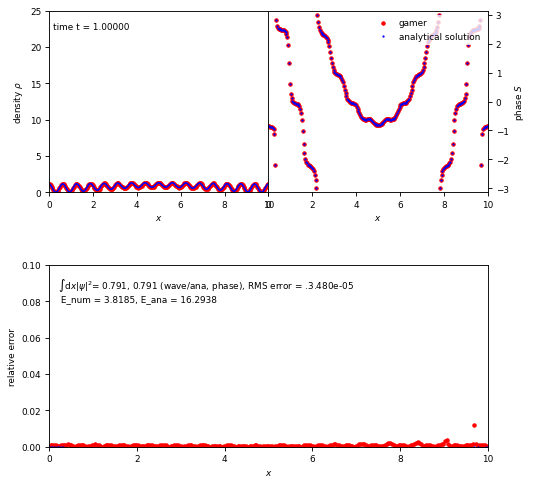

In [4]:
def extraConfig(c):
    c["nThreads"] = 2
    c["resolution"] = 256
    #c["phaseYlim"] = [-100, 100]
    c["dpi"] = 80
    c["fps"] = 1
    c["slowDown"] = 10
    c["tEnd"] = 1.0
    c["outputTimestep"] = True
    c["stencilOrder"] = 6
    c["timeOrder"] = 1
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 25]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, 10]
    c["domainSize"] = [0, 10]
    c["usePeriodicBC"] = False
c = config.generateConfig()
extraConfig(c)
scheme = wave_schemes.GAMERScheme(c, periodic1DGaussian)
scheme.run()


animation.drawFrame(solver = scheme, label = "gamer", analyticalSolution = periodic1DGaussian, filename = "periodic_gs", waveSolver = None)

## The homogenised Spectral method

In [ ]:


from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft,fft2,ifft2,ifft,irfft2,rfft2
import random as random
from mpl_toolkits.mplot3d import Axes3D



## Sine-Sine transform

### Sine Type 1

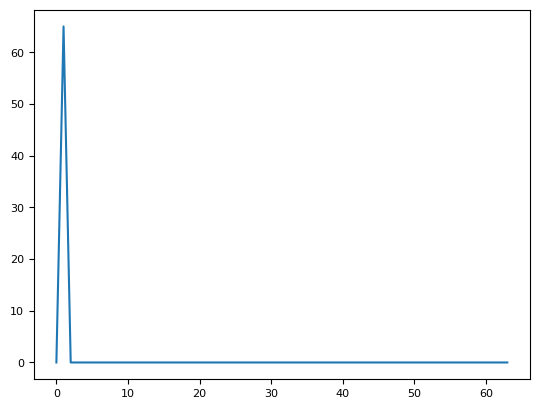

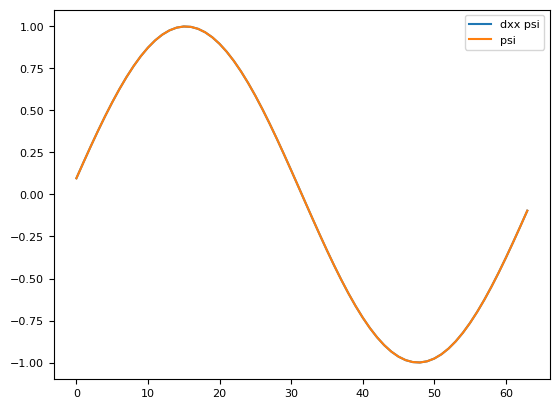

0.015384615384615385


In [ ]:

N = 64

L = 1
x = np.linspace(0, L, N + 2)[1:-1] 
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / L * np.arange(1, N+1)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 2 * np.pi 

psi = np.sin(q * x)
psihat = scipy.fft.dst(psi, type = 1)
plt.plot(psihat)
plt.show()
psihat = psihat * klin**2
hompsi = scipy.fft.idst(psihat, type = 1)
plt.plot(hompsi / q**2, label = "dxx psi")
plt.plot(psi, label = "psi")
plt.legend()
plt.show()
np.abs(psi - hompsi / q**2)
print(dx)

### Sine Type 2

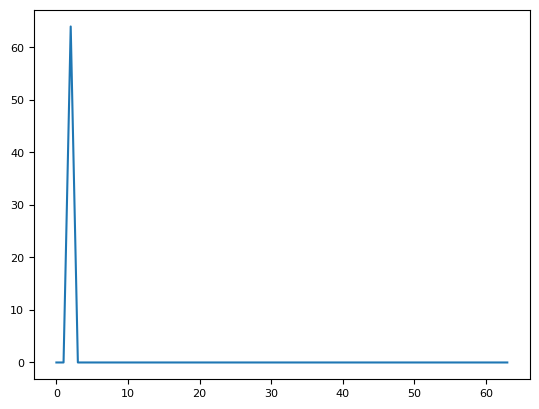

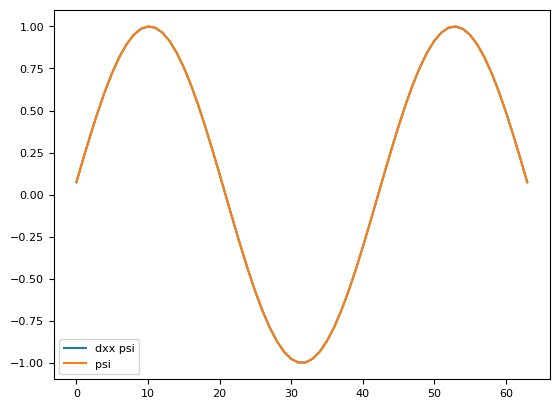

array([4.16611190e-14, 4.18276525e-14, 3.73034936e-14, 3.15858451e-14,
       4.05231404e-14, 2.93098879e-14, 1.24344979e-14, 2.83106871e-14,
       1.09912079e-14, 9.65894031e-15, 1.69864123e-14, 5.44009282e-15,
       8.88178420e-16, 1.36557432e-14, 8.43769499e-15, 2.26485497e-14,
       1.67643677e-14, 4.88498131e-15, 2.64788191e-14, 4.34097203e-14,
       4.04676292e-14, 1.31422651e-14, 1.80411242e-15, 4.18554080e-14,
       4.90718577e-14, 8.88178420e-16, 3.44169138e-15, 4.55191440e-14,
       3.26405569e-14, 6.66133815e-16, 2.06501483e-14, 2.03170814e-14,
       1.44328993e-15, 1.55431223e-15, 3.33066907e-15, 2.96429548e-14,
       6.08402217e-14, 5.56221735e-14, 6.45039577e-14, 9.25370891e-14,
       9.46465128e-14, 7.71327446e-14, 8.41618442e-14, 9.67836922e-14,
       4.09117185e-14, 3.48610030e-14, 6.87228052e-14, 6.85007606e-14,
       4.90718577e-14, 5.35127498e-14, 6.07291994e-14, 3.69704267e-14,
       4.44089210e-15, 1.29896094e-14, 8.21565038e-15, 3.48610030e-14,
      

In [ ]:

N = 64

L = 1
dx = L/(N)
x = np.linspace(0+dx/2, L - dx/2, N)
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / L * np.arange(1, N+1)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 3 * np.pi 

psi = np.sin(q * x)
psihat = scipy.fft.dst(psi, type = 2)
plt.plot(psihat)
plt.show()
psihat = psihat * klin**2
hompsi = scipy.fft.idst(psihat, type = 2)
plt.plot(hompsi / q**2, label = "dxx psi")
plt.plot(psi, label = "psi")
plt.legend()
plt.show()
np.abs(psi - hompsi / q**2)

[0.00612607 0.01814279 0.0294623  0.03964958 0.04831315 0.05512008
 0.05980877 0.06219905 0.06219905 0.05980877 0.05512008 0.04831315
 0.03964958 0.0294623  0.01814279 0.00612607]


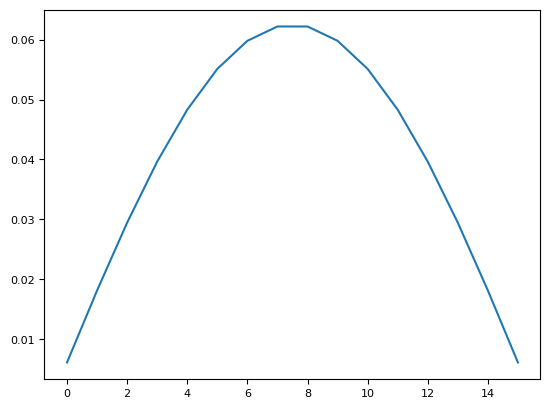

In [ ]:
N = 16

y = np.zeros(N) 
y[0] = 1
hompsi = scipy.fft.idst(y, type = 2 )
plt.plot(hompsi)
print(hompsi)

In [ ]:
x = np.linspace(0+0.125, 1-0.125, 4)
y = np.cos(2 * np.pi * x )
y /= y[0]
y *= hom[0]
y

array([ 0.00612607, -0.00612607, -0.00612607,  0.00612607])

## Cosine-Cosine transform

### Type 1

[ 6.59194921e-16  1.38273134e-14 -1.39784805e-14 -4.89750305e-15
 -4.28867607e-15  4.88791260e-15  1.23578199e-14 -1.61730508e-14
  1.59608865e-14  3.10590089e-15 -2.08653923e-14  1.41168409e-14
 -8.95998352e-15  6.97216184e-16 -6.21878628e-15  3.19744231e-14
  3.10000000e+01 -2.82571081e-14  2.31240066e-14 -7.56846176e-15
  1.95506723e-14 -1.83948694e-14  6.94161748e-15  1.00460879e-14
 -1.84103964e-14  7.54292785e-15 -7.38591441e-15  2.90089729e-15
 -4.53939266e-15  9.14901039e-15  2.05063336e-14 -4.75383621e-14]


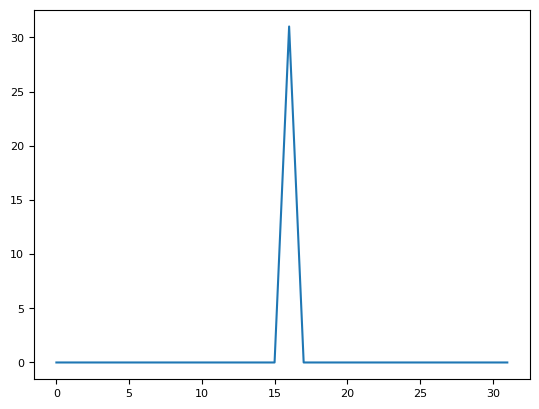

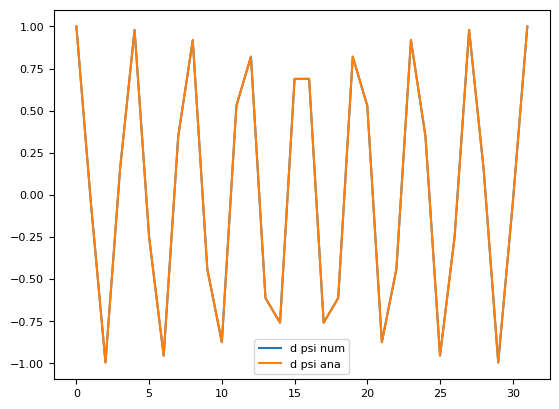

array([0.00000000e+00, 2.42861287e-16, 0.00000000e+00, 5.55111512e-17,
       3.33066907e-16, 0.00000000e+00, 5.55111512e-16, 3.33066907e-16,
       1.66533454e-15, 3.88578059e-16, 2.10942375e-15, 1.22124533e-15,
       2.99760217e-15, 1.66533454e-15, 2.55351296e-15, 1.44328993e-15,
       2.99760217e-15, 3.66373598e-15, 2.99760217e-15, 4.99600361e-15,
       2.88657986e-15, 1.88737914e-15, 3.21964677e-15, 1.55431223e-15,
       3.71924713e-15, 7.10542736e-15, 3.71924713e-15, 6.10622664e-15,
       2.05391260e-15, 1.66533454e-15, 1.31838984e-15, 3.33066907e-15])

In [ ]:

N = 32

L = 4
x = np.linspace(0, L, N) 
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / L * np.arange(0, N)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 4 * np.pi 

psi  = np.cos(q * x)
dpsi = np.cos(q * x)
psihat = scipy.fft.dct(psi, type = 1)
print(psihat)
plt.plot(psihat)
plt.show()
psihat = psihat * klin**2 
hom = scipy.fft.idct(psihat, type = 1)
plt.plot(hom / q**2, label = "d psi num")
plt.plot(dpsi, label = "d psi ana")
plt.legend()
plt.show()
np.abs(dpsi - hom / q**2)

### Type 2

[ 2.48689958e-14 -2.00211606e-14  8.17646730e-15  5.71840377e-15
 -8.55931823e-15  3.94107786e-15 -2.96725893e-15  5.52270620e-16
 -4.30195295e-15  4.54703299e-15 -4.13662678e-15  7.33467590e-15
 -5.15942375e-15  1.24324088e-14 -3.09199956e-15  1.10540864e-14
  3.20000000e+01 -3.44011792e-14  2.03287825e-14  3.47272152e-16
 -1.20825571e-15  6.84527420e-16  6.46782616e-15 -7.60491580e-15
  1.10214492e-15  2.69796529e-15 -2.61977867e-15 -2.90468632e-15
  4.72360912e-15 -1.85689819e-15 -2.38016946e-15  3.64106497e-15]


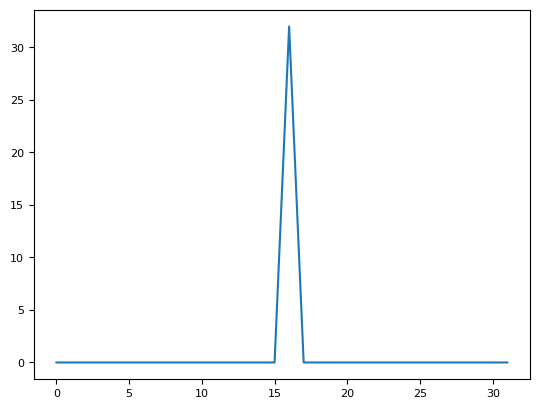

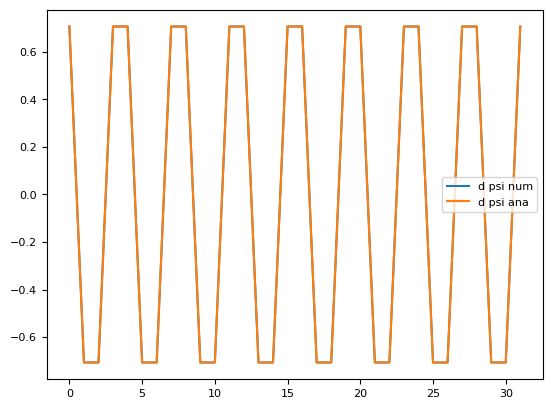

array([2.22044605e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       4.44089210e-16, 2.22044605e-16, 2.22044605e-16, 2.22044605e-16,
       1.11022302e-16, 2.22044605e-16, 1.11022302e-16, 1.11022302e-16,
       0.00000000e+00, 1.11022302e-16, 1.11022302e-16, 0.00000000e+00,
       1.11022302e-16, 1.11022302e-16, 6.66133815e-16, 2.22044605e-15,
       6.66133815e-16, 1.55431223e-15, 8.88178420e-16, 1.44328993e-15,
       1.33226763e-15, 1.11022302e-15, 1.11022302e-15, 1.44328993e-15,
       1.55431223e-15, 1.11022302e-15, 1.44328993e-15, 2.22044605e-16])

In [ ]:

N = 32

L = 4

dx = L/N 
x = np.linspace(0+dx/2, L-dx/2, N) 
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / L * np.arange(0, N)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 4 * np.pi 

psi  = np.cos(q * x)
dpsi = np.cos(q * x)
psihat = scipy.fft.dct(psi, type = 2)
print(psihat)
plt.plot(psihat)
plt.show()
psihat = psihat * klin**2 
hom = scipy.fft.idct(psihat, type = 2)
plt.plot(hompsi / q**2, label = "d psi num")
plt.plot(dpsi, label = "d psi ana")
plt.legend()
plt.show()
np.abs(dpsi - hompsi / q**2)

## Sine-Cosine Transform

[0.0625 0.1875 0.3125 0.4375 0.5625 0.6875 0.8125 0.9375 1.0625 1.1875
 1.3125 1.4375 1.5625 1.6875 1.8125 1.9375]
[ 0.38268343  0.92387953  0.92387953  0.38268343 -0.38268343 -0.92387953
 -0.92387953 -0.38268343  0.38268343  0.92387953  0.92387953  0.38268343
 -0.38268343 -0.92387953 -0.92387953 -0.38268343]


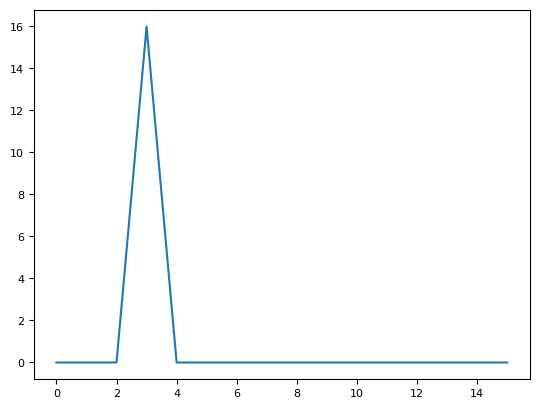

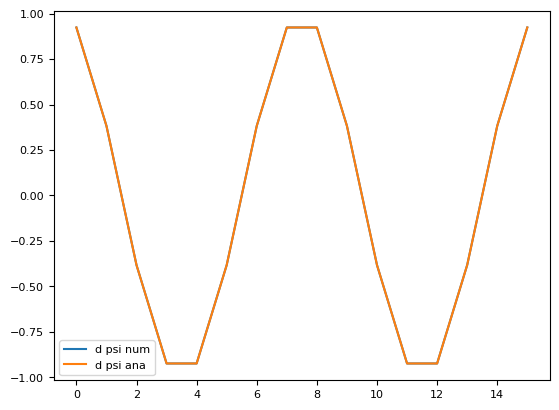

array([1.11022302e-16, 4.44089210e-16, 3.33066907e-16, 3.33066907e-16,
       1.11022302e-16, 1.49880108e-15, 1.88737914e-15, 3.33066907e-16,
       6.66133815e-16, 2.05391260e-15, 1.94289029e-15, 5.55111512e-16,
       5.55111512e-16, 2.22044605e-15, 2.44249065e-15, 1.33226763e-15])

In [ ]:

N = 16

L = 2
dx = L/N
x = np.linspace(0+dx/2, L-dx/2, N)
print(x)
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / (L) * np.arange(0, N)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 2 * np.pi 

psi  = np.sin(q * x)
dpsi = np.cos(q * x)
print(psi)
psihat = scipy.fft.dst(psi, type = 2)
plt.plot(psihat)
plt.show()
psihat = np.roll(psihat, 1)
psihat[0] = 0
psihat = psihat * klin
#plt.plot(psihat)
hompsi = scipy.fft.idct(psihat, type = 2)
plt.plot(hompsi / q, label = "d psi num")
plt.plot(dpsi, label = "d psi ana")
plt.legend()
plt.show()
np.abs(hompsi/ q- dpsi)

## Cosine-Sine Transform

[0.03125 0.09375 0.15625 0.21875 0.28125 0.34375 0.40625 0.46875 0.53125
 0.59375 0.65625 0.71875 0.78125 0.84375 0.90625 0.96875]
[ 0.99518473  0.95694034  0.88192126  0.77301045  0.63439328  0.47139674
  0.29028468  0.09801714 -0.09801714 -0.29028468 -0.47139674 -0.63439328
 -0.77301045 -0.88192126 -0.95694034 -0.99518473]


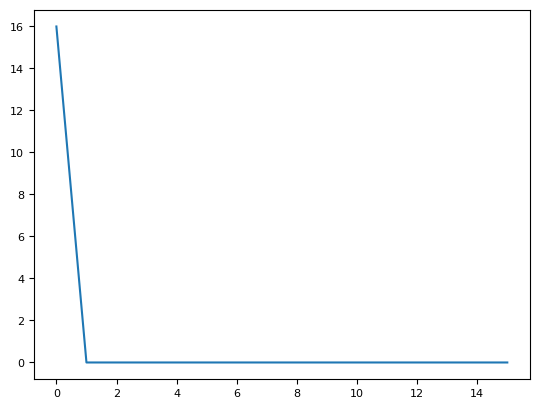

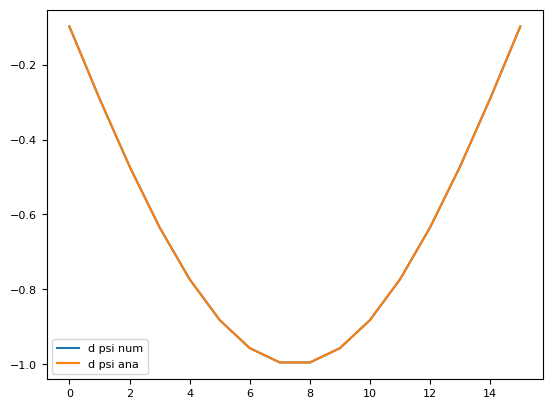

array([1.79023463e-15, 1.11022302e-15, 1.27675648e-15, 9.99200722e-16,
       2.22044605e-16, 6.66133815e-16, 1.11022302e-16, 4.44089210e-16,
       5.55111512e-16, 1.77635684e-15, 2.44249065e-15, 1.77635684e-15,
       3.10862447e-15, 3.77475828e-15, 3.83026943e-15, 4.91273688e-15])

In [ ]:

N = 16

L = 1
dx = L/N
x = np.linspace(0+dx/2, L-dx/2, N)
print(x)
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / (L) * np.arange(1, N+1)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 1 * np.pi 

psi  = np.cos(q * x)
dpsi = -np.sin(q * x)
print(psi)
psihat = scipy.fft.dct(psi, type = 2)
psihat = np.roll(psihat,-1)
plt.plot(psihat)
plt.show()
#psihat[-1] = 0
psihat = psihat * klin
#plt.plot(psihat)
hompsi = scipy.fft.idst(-psihat, type = 2)
plt.plot(hompsi / q, label = "d psi num")
plt.plot(dpsi, label = "d psi ana")
plt.legend()
plt.show()
np.abs(hompsi/ q- dpsi)


## Sine-Cosine-Sine Transform

[0.0625 0.1875 0.3125 0.4375 0.5625 0.6875 0.8125 0.9375 1.0625 1.1875
 1.3125 1.4375 1.5625 1.6875 1.8125 1.9375]


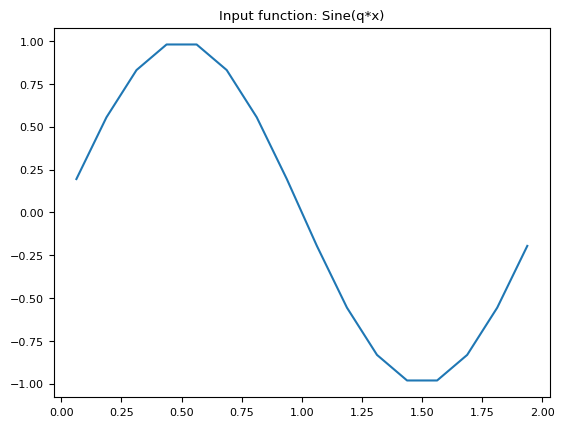

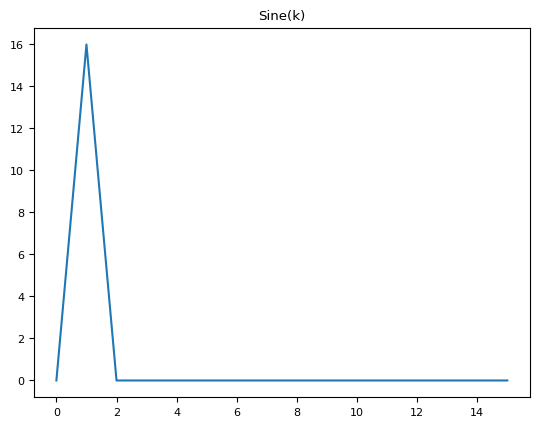

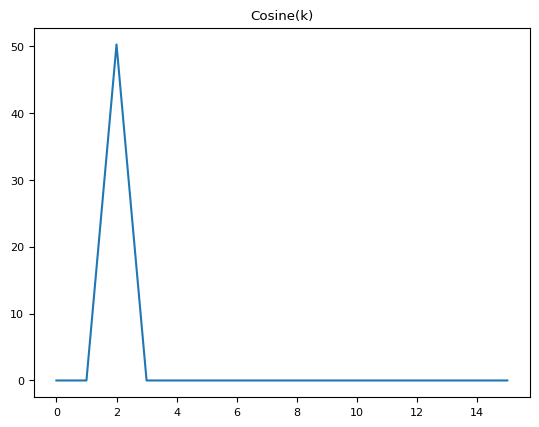

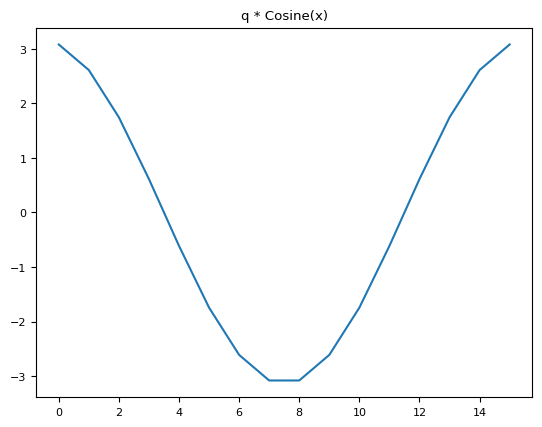

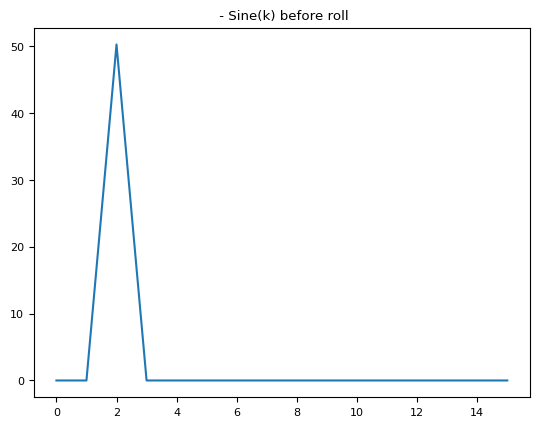

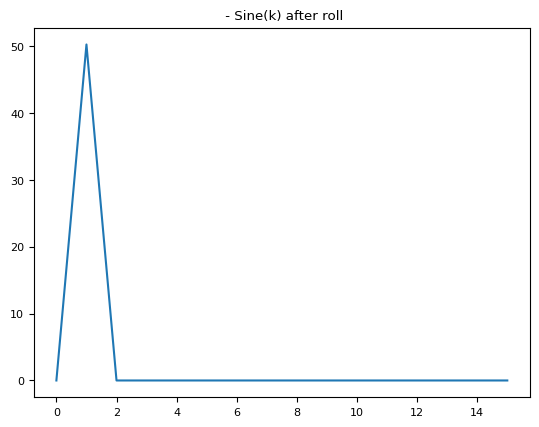

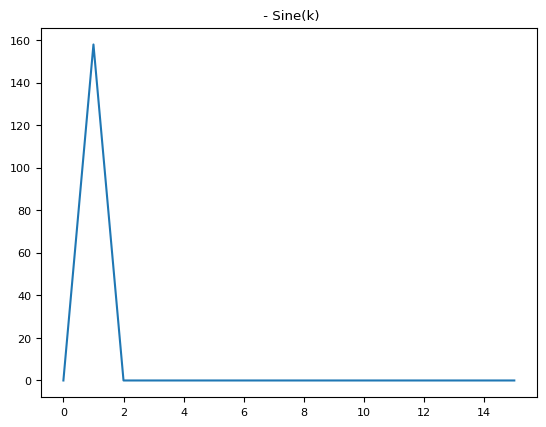

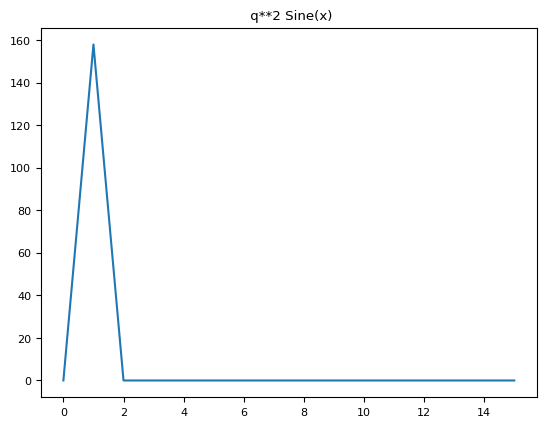

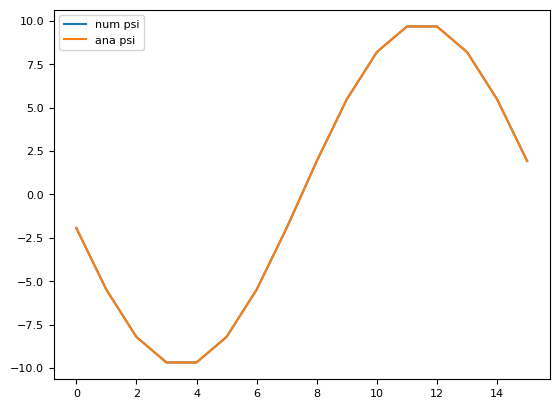

array([5.55111512e-14, 4.17443857e-14, 1.42108547e-14, 5.32907052e-15,
       1.24344979e-14, 1.77635684e-14, 2.66453526e-14, 3.37507799e-14,
       3.26405569e-14, 1.33226763e-14, 3.55271368e-15, 0.00000000e+00,
       1.59872116e-14, 3.55271368e-14, 7.10542736e-14, 1.22790667e-13])

In [ ]:

N = 16

L = 2
dx = L/N
x = np.linspace(0+dx/2, L-dx/2, N)
print(x)
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
k_sin = np.pi / (L) * np.arange(1, N+1)
k_cos = np.pi / (L) * np.arange(0, N  )

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 1 * np.pi 

hompsi  = np.sin(q * x)
plt.title("Input function: Sine(q*x)")
plt.plot(x, hompsi)
plt.show()

psihat = scipy.fft.dst(hompsi, type = 2)
plt.title("Sine(k)")
plt.plot(psihat)
plt.show()
psihat = np.roll(psihat, 1)
psihat[0] = 0
psihat = psihat * k_cos
plt.title("Cosine(k)")
plt.plot(psihat)
plt.show()
hompsi = scipy.fft.idct(psihat, type = 2)

plt.title("q * Cosine(x)")
plt.plot(hompsi)
plt.show()
psihat = scipy.fft.dct(hompsi, type = 2)

plt.title(" - Sine(k) before roll")
plt.plot(psihat)
plt.show()

psihat = np.roll(psihat,-1)

plt.title(" - Sine(k) after roll")
plt.plot(psihat)
plt.show()
psihat[-1] = 0
psihat = psihat * k_sin

plt.title(" - Sine(k)")
plt.plot(psihat)
plt.show()

hompsi = scipy.fft.idst(-psihat, type = 2)


plt.title(" q**2 Sine(x)")
plt.plot(psihat)
plt.show()
plt.plot(hompsi, label = "num psi")
plt.plot(- q**2 * np.sin(q * x), label = "ana psi")
plt.legend()
plt.show()

np.abs(- q**2 * np.sin(q * x) - hompsi)


In [ ]:


def get_x(L, N):
    dx = L/N
    xx = np.linspace(0+dx/2, L-dx/2, N)
    return xx

def get_k_sin(L, N):
    k_sin = np.pi / (L) * np.arange(1, N+1)
    return k_sin

def get_k_cos(L, N):
    k_cos = np.pi / (L) * np.arange(0, N  )
    return k_cos

def sin_derivative(psi, k_cos):
    psihat = scipy.fft.dst(psi, type = 2)
    psihat = np.roll(psihat, 1)
    psihat[0] = 0
    psihat = psihat * k_cos
    psi = scipy.fft.idct(psihat, type = 2)
    return psi


def cos_derivative(psi, k_sin):
    psihat = scipy.fft.dct(psi, type = 2)
    psihat = np.roll(psihat,-1)
    psihat[-1] = 0
    psihat = psihat * k_sin
    psi = scipy.fft.idst(-psihat, type = 2)
    return psi 



## Everything works nicely with the correct BC

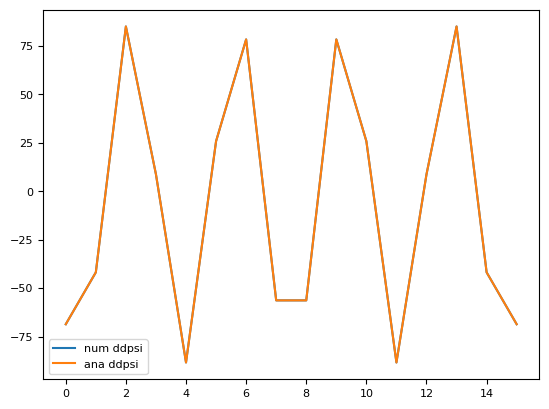

array([2.84217094e-14, 7.10542736e-15, 2.84217094e-14, 2.13162821e-14,
       5.68434189e-14, 2.48689958e-14, 8.52651283e-14, 1.42108547e-14,
       5.68434189e-14, 4.26325641e-14, 2.84217094e-14, 7.10542736e-14,
       3.55271368e-15, 4.26325641e-14, 4.26325641e-14, 2.13162821e-13])

In [ ]:


N = 16
L = 3
q = 3  * np.pi 
xx   = get_x(L, N) 
k_cos = get_k_cos(L, N)
k_sin = get_k_sin(L, N)
psi   = np.sin(q * xx)
dpsi  = sin_derivative(psi, k_cos)
ddpsi = cos_derivative(dpsi, k_sin)



plt.plot(ddpsi, label = "num ddpsi")
plt.plot(- q**2 * np.sin(q * xx), label = "ana ddpsi")
plt.legend()
plt.show()

np.abs(- q**2 * np.sin(q * xx) - ddpsi)

## But what if we cannot respect BC?

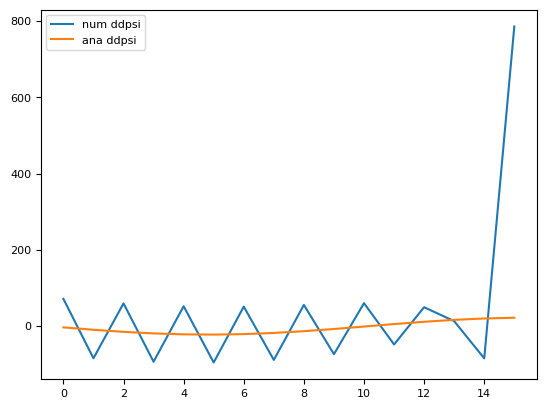

array([ 74.8324983 ,  74.73575028,  74.53463899,  74.21263104,
        73.7412742 ,  73.07451877,  72.13827691,  70.81076863,
        68.8836395 ,  65.97951233,  61.36061738,  53.42887157,
        38.19348266,   3.36009927, 104.58182877, 763.47995464])

In [ ]:


N = 16
L = 1
q = 1.5  * np.pi 
xx   = get_x(L, N) 
k_cos = get_k_cos(L, N)
k_sin = get_k_sin(L, N)
psi   = np.sin(q * xx)
dpsi  = sin_derivative(psi, k_cos)
ddpsi = cos_derivative(dpsi, k_sin)



plt.plot(ddpsi, label = "num ddpsi")
plt.plot(- q**2 * np.sin(q * xx), label = "ana ddpsi")
plt.legend()
plt.show()

np.abs(- q**2 * np.sin(q * xx) - ddpsi)

## How to fix it? Tranform to homogeneous solution!

In [3]:


N = 16
L = 1
q = 1.5  * np.pi 
xx   = get_x(L, N)
k_cos = get_k_cos(L, N)
k_sin = get_k_sin(L, N)
psi   = np.sin(q * xx)
psi1  = np.sin(q * L)
psi0  = np.sin(q * 0)
Ll    = 0
Lh    = L 

C = (psi1 - psi0)/(Lh - Ll)
B = (psi0 + C * (xx - Ll))
hompsi = (psi - B)

dpsi  = sin_derivative(hompsi, k_cos)

plt.title("First derivative")
plt.plot(dpsi + C, label = "num dpsi")
plt.plot(q * np.cos(q * xx), label = "ana dpsi")
plt.legend()
plt.show()

#ddpsi = cos_derivative(dpsi, k_sin)

psihat    = scipy.fft.dct(dpsi, type = 2)
psihatana = scipy.fft.dct(q * np.cos(q * xx), type = 2)


plt.title("First derivative in frequency space")
plt.plot(psihat, label = "num dpsi")
plt.plot(psihatana, label = "ana dpsi")
plt.legend()
plt.show()

psihat = np.roll(psihat,-1)
psihat[-1] = 0
psihat = psihat * k_sin


psihatana = np.roll(psihatana,-1)
psihatana[-1] = 0
psihatana = psihatana * k_sin

plt.title("Second derivative in frequency space")
plt.plot(psihat, label = "num dpsi")
plt.plot(psihatana , label = "ana dpsi")
plt.legend()
plt.show()


ddpsi = scipy.fft.idst(-psihat, type = 2)


plt.title("Second derivative")
plt.plot(ddpsi, label = "num ddpsi")
plt.plot(- q**2 * np.sin(q * xx), label = "ana ddpsi")
plt.legend()
plt.show()

np.abs(- q**2 * np.sin(q * xx) - ddpsi)



NameError: name 'get_x' is not defined

## The homogeneous method

### Definitions

In [29]:
import scipy as sp 

DCT1 = 1    # WSWS
DCT2 = 2    # HSHS
DCT3 = 3    # WSWA
DCT4 = 4    # HSHA
DST1 = 5    # WAWA
DST2 = 6    # HAHA
DST3 = 7    # WAWS
DST4 = 8    # HAHS
DFT1 = 9    # PERIODIC

NN       = DCT1 
ND       = DCT3
DN       = DST3
DD       = DST1
PERIODIC = DFT1

#Note:
#for DFT1 N has to be uneven to function well 
def computeX(L0, L1, N):
    L  = L1 - L0 
    dx = L/(N - 1)
    xx = np.arange(0, N) * dx + L0
    return xx, dx


def selectBC(psi, bc_ind):
    Nx = len(psi) 

    # define which transforms to use
    if bc_ind == NN:
            
        # Neumann-Neumann / WSWS
        T1 = DCT1
        
        # set indices for representative sample
        ind1 = 0
        ind2 = Nx
            
    elif bc_ind == ND:
            
        # Neumann-Dirichlet / WSWA
        T1 = DCT3
        
        # set indices for representative sample
        ind1 = 0
        ind2 = Nx - 1
            
    elif bc_ind == DN:
            
        # Dirichlet-Neumann / WAWS
        T1 = DST3
        
        # set indices for representative sample
        ind1 = 1
        ind2 = Nx

    elif bc_ind == DD:

        # Dirichlet-Dirichlet / WAWA
        T1 = DST1
        
        # set indices for representative sample
        ind1 = 1
        ind2 = Nx - 1

    elif bc_ind == PERIODIC:

        # Periodic
        T1 = DFT1 

        # set indices for representative sample
        ind1 = 0
        ind2 = Nx - 1 

    
    # assign initial condition for p, just selecting representative sample
    p = psi[ind1 : ind2]
    return p, ind1, ind2 

def computeK(p, dx, T1): 
    N = len(p) 

    #WSWS
    if T1 == DCT1:
        M = 2 * ( N - 1 )
        n = np.arange(0, int(M/2) + 1)
        k = 2 * np.pi / ( M * dx ) * n
    #HSHS
    elif T1 == DCT2:
        M = 2 * N 
        n = np.arange(0, int(M/2)    ) 
        k = 2 * np.pi / ( M * dx ) * n
    #WAWA
    elif T1 == DST1:
        M = 2 * ( N + 1 )        
        n = np.arange(1, int(M/2)    ) 
        k = 2 * np.pi / ( M * dx ) * n
    #HAHA
    elif T1 == DST2:
        M = 2 * N         
        n = np.arange(1, int(M/2) + 1)
        k = 2 * np.pi / ( M * dx ) * n
    #WSWA or HSHA or WAWS or HAHS
    elif T1 == DCT3 or T1 == DCT4 or T1 == DST3 or T1 == DST4:
        M = 2 * N 
        n = np.arange(0, int(M/2)   )
        k = 2 * np.pi / ( M * dx ) * (n + 0.5)
    elif T1 == DFT1:
        n = np.arange(-N/2, N/2)
        k = 2 * np.pi / ( N * dx ) * n 
        k = np.fft.ifftshift(k) 

    return k 

def laplacianDtt1D(p, dx, T1):
    k = computeK(p, dx, T1) 

    if   T1 <= DCT4:
        p_hat = sp.fft.dct(p, type = T1)
    elif T1 <= DST4: 
        p_hat = sp.fft.dst(p, type = T1 - 4)
    else:
        p_hat = sp.fft.fft(p) 

    p_hat = p_hat * (-1) * k**2

    if   T1 <= DCT4:
        pn = sp.fft.idct(p_hat, type = T1)
    elif T1 <= DST4: 
        pn = sp.fft.idst(p_hat, type = T1 - 4)
    else:
        pn = sp.fft.ifft(p_hat) 

    return pn, k 

## DST 1 - Dirichlet - Dirichlet BC

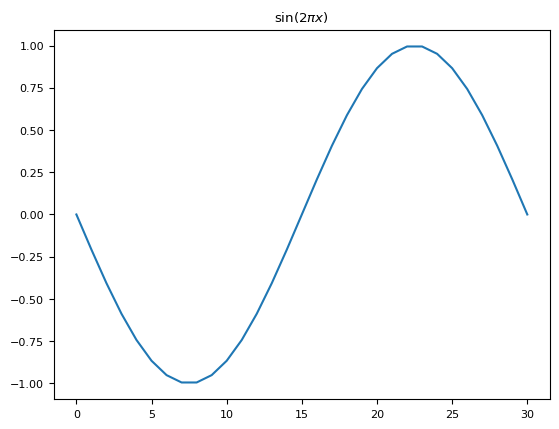

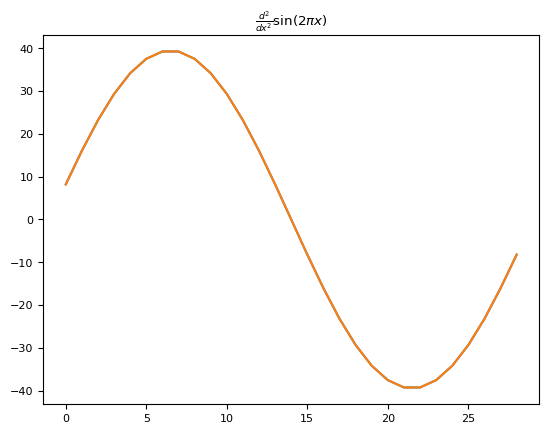

2.6928360537105663e-13

In [373]:
x, dx = computeX(-0.5, 0.5, 30)
q = 2* np.pi
f = np.sin( q * x) 
plt.title(r"$\sin(2 \pi x)$")
plt.plot(f)
plt.show()
p, ind1, ind2 = selectBC(f, DD)
xi = x[ind1: ind2]
ddfana, k = laplacianDtt1D(p,dx, DD )
ddfnum = -q**2 * np.sin(q * xi)
plt.title(r"$\frac{d^2}{dx^2}\sin(2 \pi x)$")
plt.plot(ddfana)
plt.plot(ddfnum)
plt.show()

np.mean(np.abs(ddfana - ddfnum))


## DST 3 - Dirichlet-Neumann BC

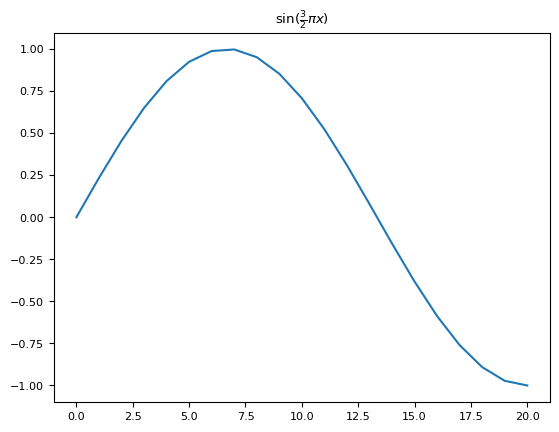

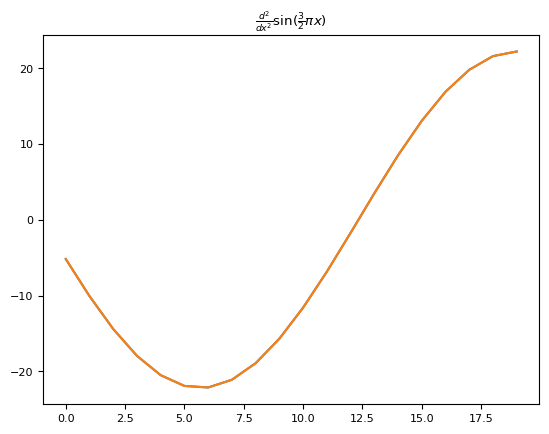

2.387534614456399e-13

In [374]:
x, dx = computeX(0,1, 20) 
q = 3 / 2 * np.pi
f = np.sin( q * x ) 
plt.title(r"$\sin(\frac{3}{2} \pi x)$")
plt.plot(f)
plt.show()
p, ind1, ind2 = selectBC(f, DN)
xi = x[ind1: ind2]
ddfana, k = laplacianDtt1D(p,dx, DN)
ddfnum = -q**2 * np.sin(q * xi)
plt.title(r"$\frac{d^2}{dx^2}\sin(\frac{3}{2} \pi x)$")
plt.plot(ddfana)
plt.plot(ddfnum)
plt.show()

np.mean(np.abs(ddfana - ddfnum))


## DCT 1 - Neumann-Neumann BC

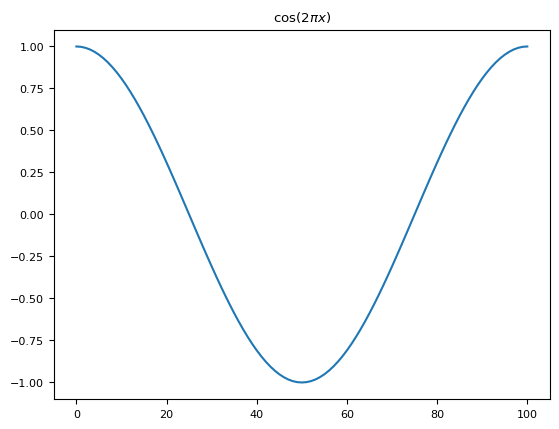

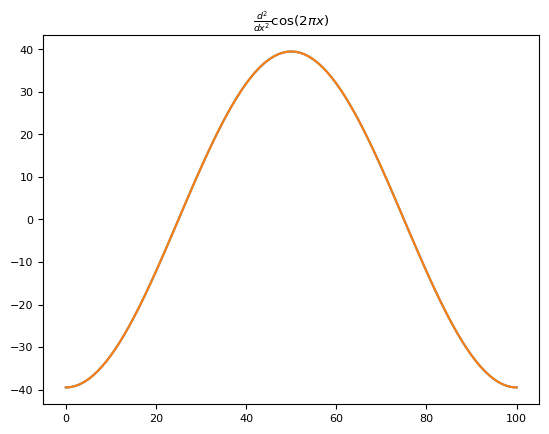

1.0954550741046455e-11

In [375]:
x, dx = computeX(0, 1, 100)
q = 2 * np.pi
f = np.cos( q * x ) 
plt.title(r"$\cos(2 \pi x)$")
plt.plot(f)
plt.show()
p, ind1, ind2 = selectBC(f, NN)
xi = x[ ind1 : ind2 ]
ddfnum, k = laplacianDtt1D(p,dx, NN)
ddfana = -q**2 * np.cos(q * xi)
plt.title(r"$\frac{d^2}{dx^2}\cos(2 \pi x)$")
plt.plot(ddfana)
plt.plot(ddfnum)
plt.show()

np.mean(np.abs(ddfana - ddfnum))


## DCT 3 - Neumann-Dirichlet BC

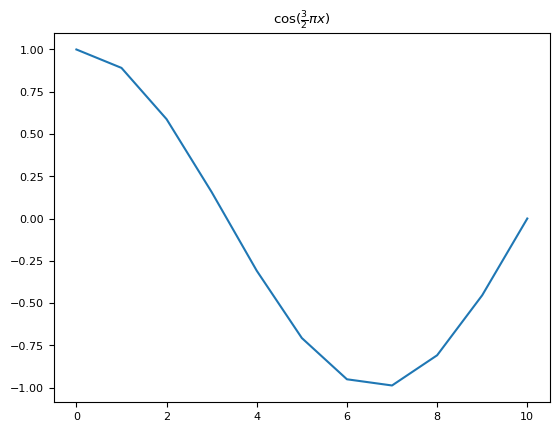

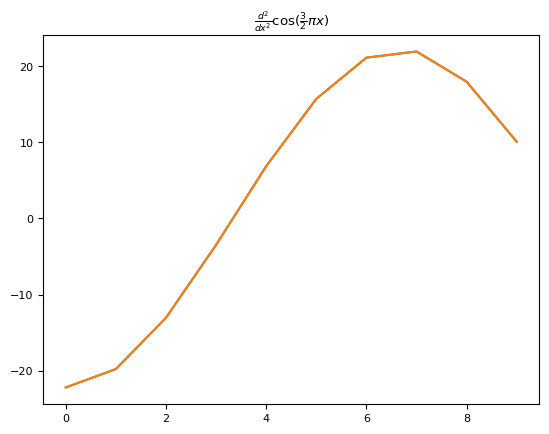

5.759837051755312e-14

In [376]:
x, dx= computeX(0, 1, 10)
q = 1.5 * np.pi  / (x[-1] - x[0])
f = np.cos( q * x ) 
plt.title(r"$\cos(\frac{3}{2} \pi x)$")
plt.plot(f)
plt.show()
p, ind1, ind2 = selectBC(f, ND)
xi = x[ ind1 : ind2 ]
ddfnum, k = laplacianDtt1D(p,dx, ND)
ddfana    = -q**2 * np.cos(q * xi)
plt.title(r"$\frac{d^2}{dx^2}\cos(\frac{3}{2} \pi x)$")
plt.plot(ddfana)
plt.plot(ddfnum)
plt.show()

np.mean(np.abs(ddfana - ddfnum))


## Sum of all BC

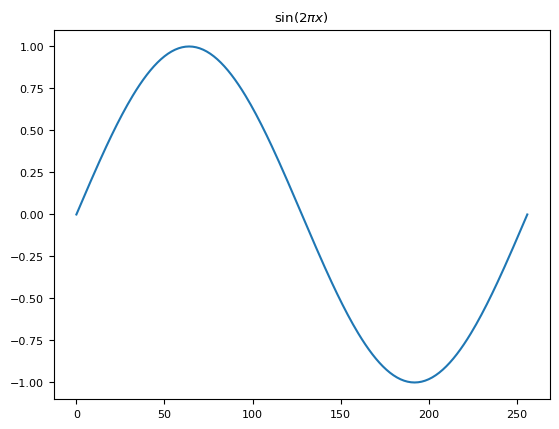

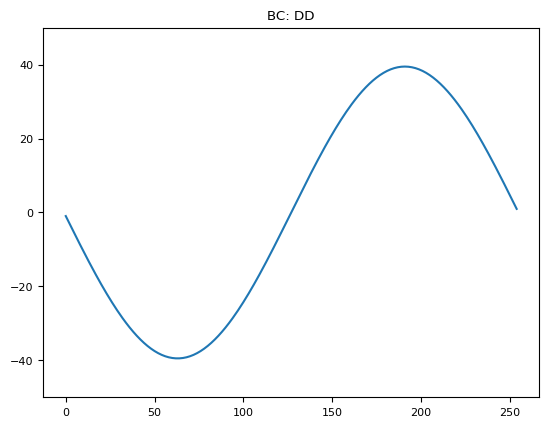

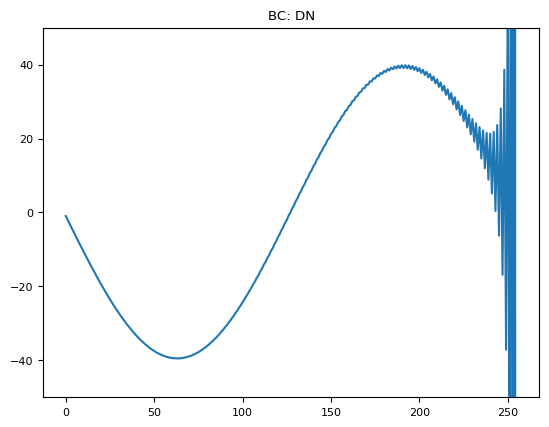

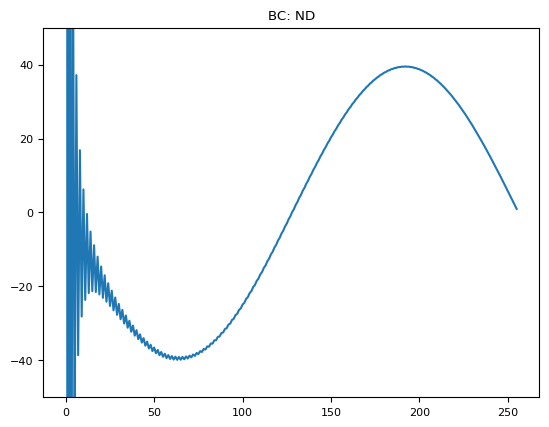

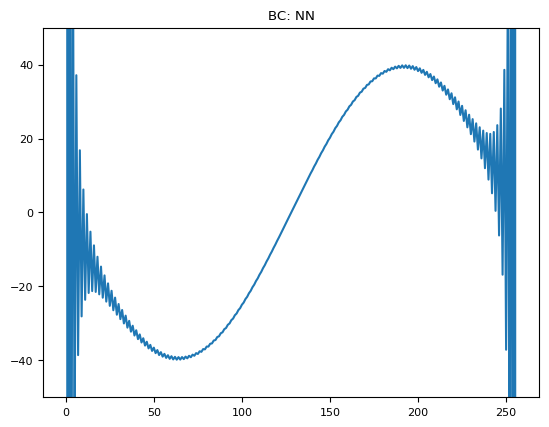

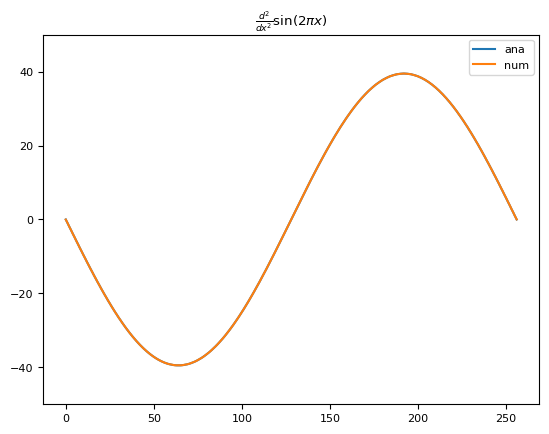

0.01329610559878303

In [401]:
x, dx= computeX(0, 1, 256)
q = 2 * np.pi
f = np.sin( q * x) 
plt.title(r"$\sin(2 \pi x)$")
plt.plot(f)
plt.show()

BCs = [DD, DN, ND, NN]
BC_txt = ["DD", "DN", "ND", "NN"]
prefactors = np.array([ 2, -1, -1, 1])
ddfnum = np.zeros(x.shape)
ddfnums = np.zeros((*x.shape, 4))

for i, BC in enumerate(BCs): 
    p, ind1, ind2 = selectBC(f, BC)
    ddfnum_part, k = laplacianDtt1D(p, dx, BC)
    plt.title(f"BC: {BC_txt[i]}")
    plt.ylim([-50, 50])
    plt.plot(ddfnum_part)
    plt.show()
    ddfnums[ind1:ind2, i] = ddfnum_part


    ddfnum[ind1:ind2] += 1 * prefactors[i] * ddfnum_part

ddfana    = - q**2 * np.sin(q * x )
plt.title(r"$\frac{d^2}{dx^2}\sin(2 \pi x)$")
plt.plot(ddfana, label="ana")
plt.plot(ddfnum, label="num")
plt.ylim([-50, 50])
plt.legend()
plt.show()

np.mean(np.abs(ddfana - ddfnum))


## Solving the wave equation

### The finite difference solution

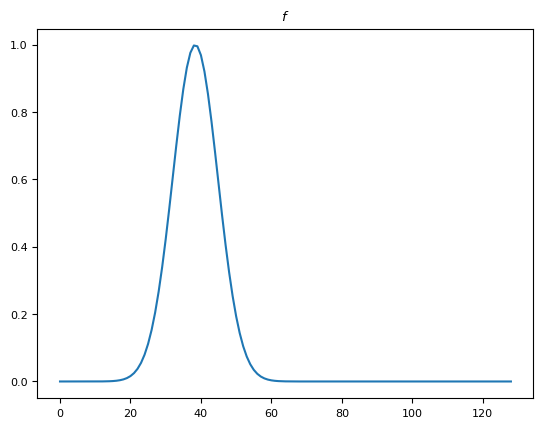

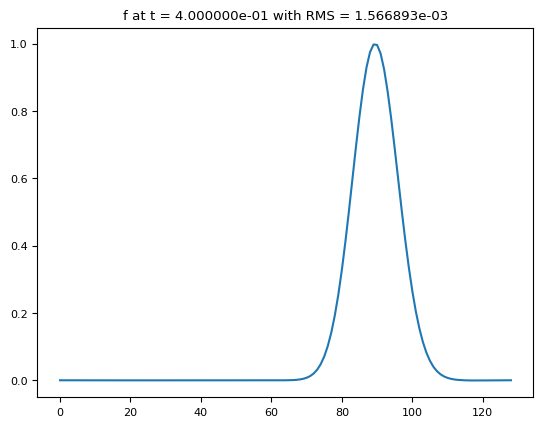

In [7]:
import scipy as sp 

L = 1
N = 128
x, dx = computeX(0, L, N)
dt = 1e-4
v = 1
t = 0
r = (v * dt/dx)**2

def func(x, v, t):
    return np.exp(-(x-0.3 - t * v)**2/0.005)

f  = func(x, v,   0)
fm = func(x, v, -dt)

plt.title(r"$f$")
plt.plot(f)
plt.show()

for i in range(4000):
    fp = 2 * f - fm + r * (np.roll(f, -1) - 2 * f + np.roll(f, 1))
    fm = f 
    f  = fp
    t += dt 

plt.title(f"f at t = {t:3e} with RMS = {np.mean(np.abs(f - func(x, v, t))):3e}")
plt.plot(f)
plt.show()

### The fancy spectral solution

(128, 2, 4)


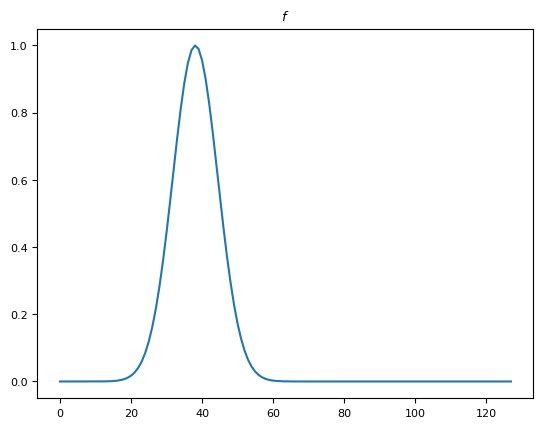

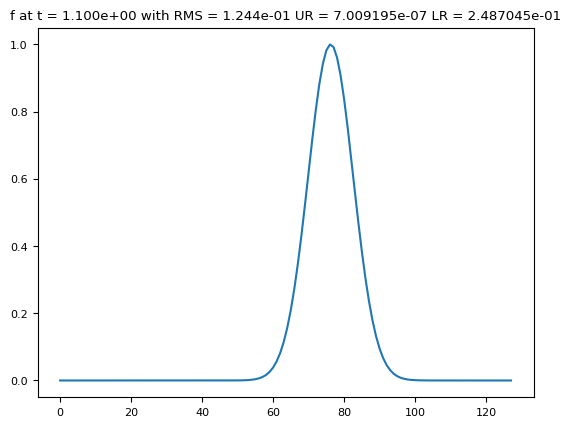

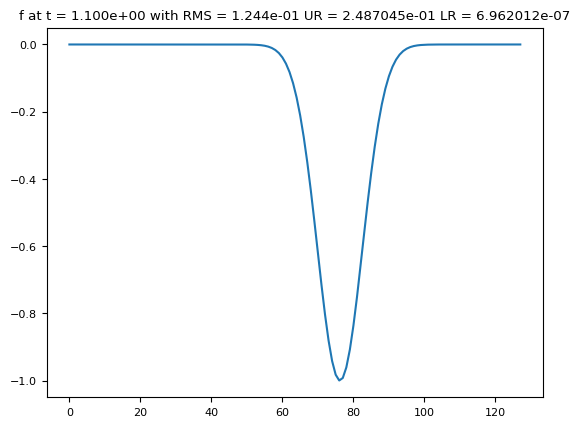

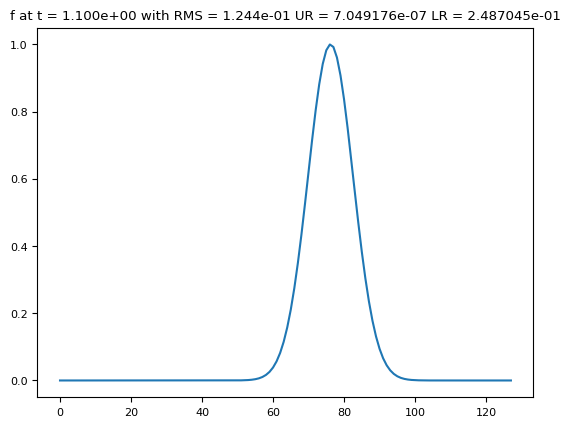

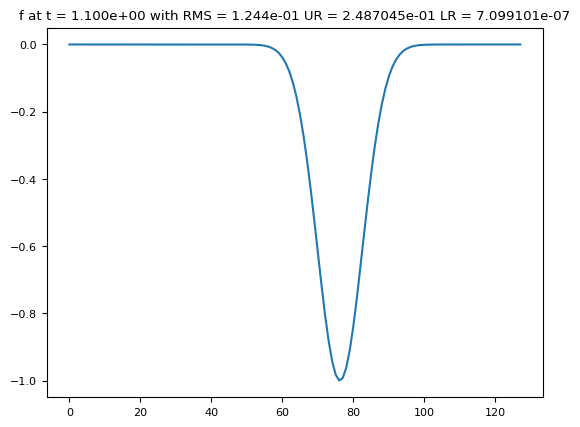

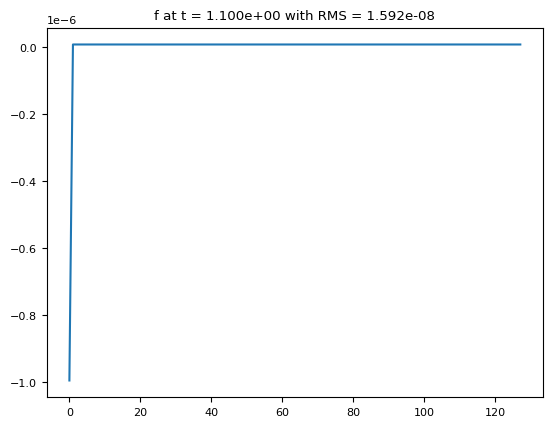

In [113]:
L = 1
N = 128
x, dx = computeX(0, L, N)
dt = 1e-4
v = 1
t = 0
r = (v * dt)**2

def func(x, v, t):
    return np.exp(-(x-0.3 - t * v)**2/0.005)

def UR(x, v, t):
    return np.exp(-(x-1.7 + t * v)**2/0.005)

t0 = 0.0

f  = func(x, v,   t0     )
fm = func(x, v,   t0 - dt)

fs = np.zeros((*f.shape, 2, 4))
print(fs.shape)
fs[:, 0, 0] = f
fs[:, 1, 0] = fm
fs[:, 0, 1] = f
fs[:, 1, 1] = fm
fs[:, 0, 2] = f
fs[:, 1, 2] = fm
fs[:, 0, 3] = f
fs[:, 1, 3] = fm

BC = NN
prefactors = np.array([ 1, 1, 1, 1]) * 0.25
ddfnum = np.zeros(x.shape)
ddfnums = np.zeros((*x.shape, 4))

plt.title(r"$f$")
plt.plot(f)
plt.show()

for i in range(11000):

    for j, BC in enumerate([NN, ND, DN, DD]):
        ddf             = np.zeros(fs[:, 0, j].shape)
        p, ind1, ind2   = selectBC(fs[:, 0, j], BC)
        ddfs, k         = laplacianDtt1D(p, dx, BC)
        ddf[ind1:ind2] += ddfs

        
        fp = 2 * fs[:, 0, j] - fs[:, 1, j] + r * ddf
        fs[:, 1, j]  = fs[:, 0, j]
        fs[:, 0, j]  = fp
    t += dt 

for j, BC in enumerate([NN, ND, DN, DD]):
    plt.title(f"f at t = {t:3.3e} with RMS = {np.mean(np.abs(fs[:, 0, j] - func(x, v, t))):3.3e} UR = {np.mean(np.abs(fs[:, 0, j] - UR(x, v, t))):3e} LR = {np.mean(np.abs(fs[:, 0, j] + UR(x, v, t))):3e}")
    plt.plot(fs[:, 0, j])
    plt.show()

plt.title(f"f at t = {t:3.3e} with RMS = {np.mean(np.abs(np.mean(fs[:, 0, :], axis=1) - 0)):3.3e}")
plt.plot(np.mean(fs[:, 0, :], axis=1))
plt.show()

## Can we get a similar result just with DD?

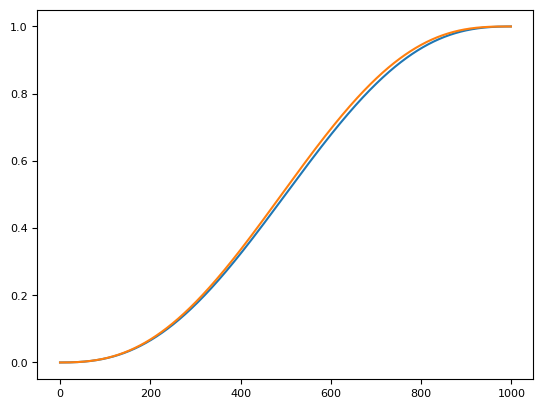

In [239]:
x = np.linspace(0, 1, 1000)

poly2 = scipy.interpolate.make_interp_spline([0, 1], [0, 1 + 1j], k = 5, bc_type=([(1, 0), (2, 1 + 1j)], [(1, 0), (2, -1)]), axis=0)

plt.plot(poly2(x).real)
plt.plot(poly2(x).imag)

In [325]:
MLINEAR            = 1
MCUBIC             = 2
MCUBIC_DD          = 3
MCUBIC_NN          = 4
MQUARTIC_NN        = 5
MCUBIC_PERIODIC    = 6
MQUINTIC_PERIODIC  = 7
MSEPTIC_PERIODIC   = 9
MNONIC_PERIODIC    = 10 

ANALYTICAL   = 1
SECOND_ORDER = 2
THIRD_ORDER  = 3
FOURTH_ORDER = 4
FIFTH_ORDER = 5
SIXTH_ORDER = 6
FOURTH_ORDER_CENTRAL = 7


def laplacianDtt1D(p, dx, T1):
    k = computeK(p, dx, T1)

    if   T1 <= DCT4:
        p_hat = sp.fft.dct(p, type = T1)
    elif T1 <= DST4: 
        p_hat = sp.fft.dst(p, type = T1 - 4)
    else:
        p_hat = sp.fft.fft(p) 

    p_hat = p_hat * (-1) * k**2

    if   T1 <= DCT4:
        pn = sp.fft.idct(p_hat, type = T1)
    elif T1 <= DST4: 
        pn = sp.fft.idst(p_hat, type = T1 - 4)
    else:
        pn = sp.fft.ifft(p_hat)

    return pn, k 

### derivatives with boundary
def getDerivatives(f, h, derivative_mode, boundary):
    i0 = + 0 + boundary 
    i1 = - 1 - boundary 

    if derivative_mode == SECOND_ORDER:
        i = i0
        df0 = (-3*f[i+0]+4*f[i+1]-1*f[i+2])/(2*1.0*h**1)
        i = i1
        df1 = (1*f[i-2]-4*f[i-1]+3*f[i+0])/(2*1.0*h**1)
    elif derivative_mode == THIRD_ORDER:
        i = i0
        df0 = (-11*f[i+0]+18*f[i+1]-9*f[i+2]+2*f[i+3])/(6*1.0*h**1)
        i = i1
        df1 = (-2*f[i-3]+9*f[i-2]-18*f[i-1]+11*f[i+0])/(6*1.0*h**1)
    elif derivative_mode == FOURTH_ORDER:
        i = i0
        df0 = (-25*f[i+0]+48*f[i+1]-36*f[i+2]+16*f[i+3]-3*f[i+4])/(12*1.0*h**1)
        i = i1
        df1 = (3*f[i-4]-16*f[i-3]+36*f[i-2]-48*f[i-1]+25*f[i+0])/(12*1.0*h**1)
    elif derivative_mode == FIFTH_ORDER: 
        i = i0
        df0 = (-137*f[i+0]+300*f[i+1]-300*f[i+2]+200*f[i+3]-75*f[i+4]+12*f[i+5])/(60*1.0*h**1)
        i = i1
        df1 = (-12*f[i-5]+75*f[i-4]-200*f[i-3]+300*f[i-2]-300*f[i-1]+137*f[i+0])/(60*1.0*h**1)
    elif derivative_mode == SIXTH_ORDER:
        i = i0
        df0 = (-147*f[i+0]+360*f[i+1]-450*f[i+2]+400*f[i+3]-225*f[i+4]+72*f[i+5]-10*f[i+6])/(60*1.0*h**1)
        i = i1
        df1 = (10*f[i-6]-72*f[i-5]+225*f[i-4]-400*f[i-3]+450*f[i-2]-360*f[i-1]+147*f[i+0])/(60*1.0*h**1)
    elif derivative_mode == FOURTH_ORDER_CENTRAL:
        i = i0
        df0 = (1*f[i-2]-8*f[i-1]+0*f[i+0]+8*f[i+1]-1*f[i+2])/(12*1.0*h**1)
        i = i1
        df1 = (1*f[i-2]-8*f[i-1]+0*f[i+0]+8*f[i+1]-1*f[i+2])/(12*1.0*h**1)
    else:
        raise ValueError(f"Unsupported derivative mode {derivative_mode} in getDerivatives!")

    return df0, df1 

def getSecondDerivatives(f, h, derivative_mode, boundary):
    i0 = + 0 + boundary 
    i1 = - 1 - boundary 

    if derivative_mode == FOURTH_ORDER_CENTRAL:
        i = i0
        ddf0 = (-1*f[i-2]+16*f[i-1]-30*f[i+0]+16*f[i+1]-1*f[i+2])/(12*1.0*h**2)
        i = i1
        ddf1 = (-1*f[i-2]+16*f[i-1]-30*f[i+0]+16*f[i+1]-1*f[i+2])/(12*1.0*h**2)
    if derivative_mode == FOURTH_ORDER:
        i = i0
        ddf0 = (35*f[i+0]-104*f[i+1]+114*f[i+2]-56*f[i+3]+11*f[i+4])/(12*1.0*h**2)
        i = i1
        ddf1 = (11*f[i-4]-56*f[i-3]+114*f[i-2]-104*f[i-1]+35*f[i+0])/(12*1.0*h**2)
    else:
        raise ValueError(f"Unsupported derivative mode {derivative_mode} in getSecondDerivatives!")

    return ddf0, ddf1


def getThirdDerivatives(f, h, derivative_mode, boundary):
    i0 = + 0 + boundary 
    i1 = - 1 - boundary 

    if derivative_mode == FOURTH_ORDER_CENTRAL:
        i = i0
        dddf0 = (-1*f[i-2]+2*f[i-1]+0*f[i+0]-2*f[i+1]+1*f[i+2])/(2*1.0*h**3)
        i = i1
        dddf1 = (-1*f[i-2]+2*f[i-1]+0*f[i+0]-2*f[i+1]+1*f[i+2])/(2*1.0*h**3)
    if derivative_mode == FOURTH_ORDER:
        i = i0
        dddf0 = (-5*f[i+0]+18*f[i+1]-24*f[i+2]+14*f[i+3]-3*f[i+4])/(2*1.0*h**3)
        i = i1
        dddf1 = ( 3*f[i-4]-14*f[i-3]+24*f[i-2]-18*f[i-1]+5*f[i+0])/(2*1.0*h**3)
    else:
        raise ValueError(f"Unsupported derivative mode {derivative_mode} in getSecondDerivatives!")

    return dddf0, dddf1

def getFourthDerivatives(f, h, derivative_mode, boundary):
    i0 = + 0 + boundary 
    i1 = - 1 - boundary 

    if derivative_mode == FOURTH_ORDER_CENTRAL:
        i = i0
        ddddf0 = (1*f[i-2]-4*f[i-1]+6*f[i+0]-4*f[i+1]+1*f[i+2])/(1*1.0*h**4)
        i = i1
        ddddf1 = (1*f[i-2]-4*f[i-1]+6*f[i+0]-4*f[i+1]+1*f[i+2])/(1*1.0*h**4)
    if derivative_mode == FOURTH_ORDER:
        i = i0
        ddddf0 = (1*f[i+0]-4*f[i+1]+6*f[i+2]-4*f[i+3]+1*f[i+4])/(1*1.0*h**4)
        i = i1
        ddddf1 = (1*f[i-4]-4*f[i-3]+6*f[i-2]-4*f[i-1]+1*f[i+0])/(1*1.0*h**4)
    else:
        raise ValueError(f"Unsupported derivative mode {derivative_mode} in getSecondDerivatives!")

    return ddddf0, ddddf1

### New shift function with boundary 
def getShiftFunction(x, f, mode, derivative_mode, boundary = 0, debug = False ):

    dx       = x [ 1 ] - x[ 0 ]
    x0       = x [ 0 + boundary ]
    x1       = x [-1 - boundary ]
    f0       = f [ 0 + boundary ]
    f1       = f [-1 - boundary ]
    df0, df1   = getDerivatives(f, dx, derivative_mode, boundary )

    rb = len(x)
    if boundary > 0:
        rb = - boundary
    lb = boundary 

    ddB   = np.zeros(f.shape)
    d4B   = np.zeros(f.shape)
    d6B   = np.zeros(f.shape)
    d8B   = np.zeros(f.shape)
    
    if mode == MLINEAR:
        #Compute linear shift function 
        slope = (f1 - f0) / (x1 - x0)
        B     = f0 + slope * ( x - x0 )
    elif mode == MCUBIC_NN: 
        #Compute cubic shift function 
        poly  = scipy.interpolate.CubicHermiteSpline([x0, x1], [f0, f1], [df0, df1], axis=0, extrapolate=None)
        B     = poly( x )
        ddB   = poly( x , 2)
    elif mode == MCUBIC_DD: 
        #Compute cubic shift function 
        poly  = scipy.interpolate.CubicHermiteSpline([x0, x1], [f0, f1], [df0, df1], axis=0, extrapolate=None)
        B     = poly( x  )
        ddB   = poly( x  , 2)
    elif mode == MCUBIC_PERIODIC:
        #Make second derivative continuous
        ddf0, ddf1 = getSecondDerivatives( f, dx, derivative_mode, boundary )        
        poly  = scipy.interpolate.make_interp_spline([x0, x1], [f0, f1], k = 3, bc_type=([(1, df0)], [(1, df1)]), axis=0)
        B     = poly( x )
        ddB   = poly( x , 2 )
    elif mode == MQUINTIC_PERIODIC:
        #Make second derivative continuous
        ddf0, ddf1 = getSecondDerivatives( f, dx, derivative_mode, boundary )        
        poly  = scipy.interpolate.make_interp_spline([x0, x1], [f0, f1], k = 5, bc_type=([(1, df0), (2, ddf0)], [(1, df1), (2, ddf1)]), axis=0)
        B     = poly( x )
        ddB   = poly( x , 2 )
        d4B   = poly( x , 4 )
    elif mode == MSEPTIC_PERIODIC:
        #Make second derivative continuous
        ddf0,  ddf1  = getSecondDerivatives( f, dx, derivative_mode, boundary )        
        dddf0, dddf1 = getThirdDerivatives ( f, dx, derivative_mode, boundary )        
        poly  = scipy.interpolate.make_interp_spline([x0, x1], [f0, f1], k = 7, bc_type=([(1, df0), (2, ddf0), (3, dddf0)], [(1, df1), (2, ddf1), (3, dddf1)]), axis=0)
        B     = poly( x )
        ddB   = poly( x , 2 )
        d4B   = poly( x , 4 )
        d6B   = poly( x , 6 )
    elif mode == MNONIC_PERIODIC:
        #Make second derivative continuous
        d2f0, d2f1 = getSecondDerivatives( f, dx, derivative_mode, boundary )        
        d3f0, d3f1 = getThirdDerivatives ( f, dx, derivative_mode, boundary )        
        d4f0, d4f1 = getFourthDerivatives ( f, dx, derivative_mode, boundary )        
        poly  = scipy.interpolate.make_interp_spline([x0, x1], [f0, f1], k = 9, bc_type=([(1, df0), (2, d2f0), (3, d3f0), (4, d4f0)], [(1, df1), (2, d2f1), (3, d3f1), (4, d4f1)]), axis=0)
        B     = poly( x )
        ddB   = poly( x , 2 )
        d4B   = poly( x , 4 )
        d6B   = poly( x , 6 )
        d8B   = poly( x , 8 )
    else:
        raise ValueError(f"Unsupported mode {mode} in getShiftFunction!")
    
    if debug:
        plt.title("f")
        plt.plot(f.real, label = "real" ) 
        plt.plot(f.imag, label = "imag" ) 
        plt.legend() 
        plt.show() 
        plt.title("B")
        plt.plot(B.real, label = "real" ) 
        plt.plot(B.imag, label = "imag" ) 
        plt.legend() 
        plt.show() 
        plt.title("f - B")
        plt.plot((f - B).real, label = "real" ) 
        plt.plot((f - B).imag, label = "imag" ) 
        plt.legend() 
        plt.show() 


    return B [ lb : rb ], ddB [ lb : rb ], d4B [ lb : rb ], d6B [ lb : rb ], d8B [ lb : rb ]



def func(x, v, t):
    return np.exp(-(x-0.3 - t * v)**2/0.005)


def run(L, N, x, dx, dt, v, r, t, BC, mode, derivative_mode, h, bc_boundary, fd_boundary): 
    f  = func(x, v,   t     )
    fm = func(x, v,   t - dt)

    fs = np.zeros((*f.shape, 2, 1))

    fs[:, 0, 0] = f
    fs[:, 1, 0] = fm

    j = 0
    counter = 0

    plt.title(r"$f$")
    plt.plot(f)
    plt.show()

    for steps in range(3000):


        #BC 
        f = fs[ :, 0, j ]
        
        #Update fs
        for i in range(bc_boundary + 1): 
            fs[     i, 0, j] = func(     i * dx, v, t)
            fs[-1 - i, 0, j] = func( L - i * dx, v, t)

        B, ddB, _, _, _ = getShiftFunction(x, f, mode, derivative_mode, boundary=fd_boundary, debug=False)

        #Boundary for finite difference stencil
        rb = len(x)
        if fd_boundary > 0:
            rb = - fd_boundary
        lb = fd_boundary 

        #Subtract linear shift function to enforce Dirichlet BC when computing second derivative
        homf            = fs[lb:rb:, 0, j] - B
        ddf             = np.zeros(len(homf))
        p, ind1, ind2   = selectBC(homf, BC)
        ddfs, k         = laplacianDtt1D(p, dx, BC)
        ddf[ind1:ind2]  = ddf[ind1:ind2] + ddfs.real
        ddf             = ddf + ddB 

        if counter % 10000 == 0:
            plt.title(f"B at t = {t}")
            plt.plot(B)
            plt.show()
            plt.title(f"homf at t = {t}")
            plt.plot(homf)
            plt.show()
            plt.title(f"Second derivative of f at t = {t}")
            plt.plot(ddf)
            plt.show()

        counter += 1
            
        fp               = 2 * fs[lb:rb, 0, j] - fs[lb:rb, 1, j] + r * ddf
        fs[lb:rb, 1, j]  = fs[lb:rb, 0, j]
        fs[lb:rb, 0, j]  = fp
        t += dt 

    plt.title(f"f at t = {t:3.3e} with RMS = {np.mean(np.abs(fs[:, 0, j] - func(x, v, t))):3.3e} UR = {np.mean(np.abs(fs[:, 0, j] - UR(x, v, t))):3e} LR = {np.mean(np.abs(fs[:, 0, j] + UR(x, v, t))):3e}")
    plt.plot(fs[:, 0, j])
    plt.show()

7.692307692307693e-07


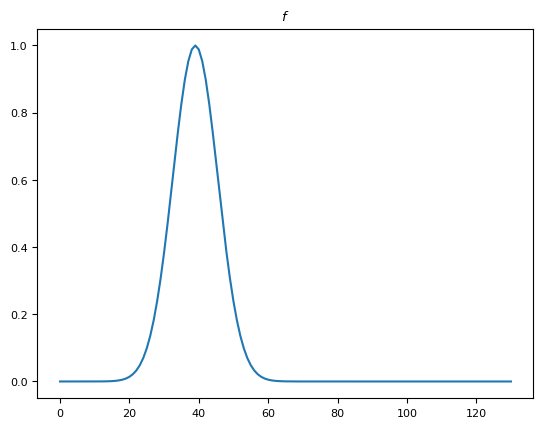

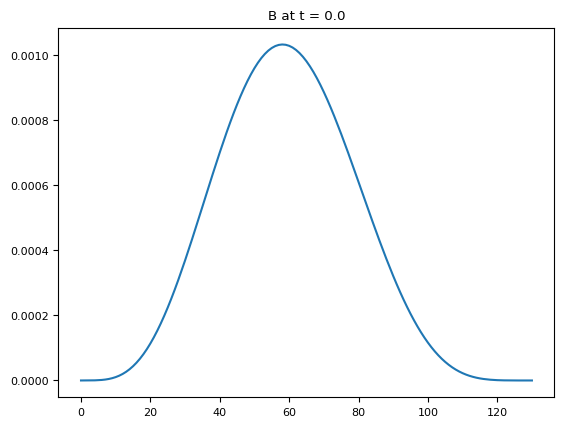

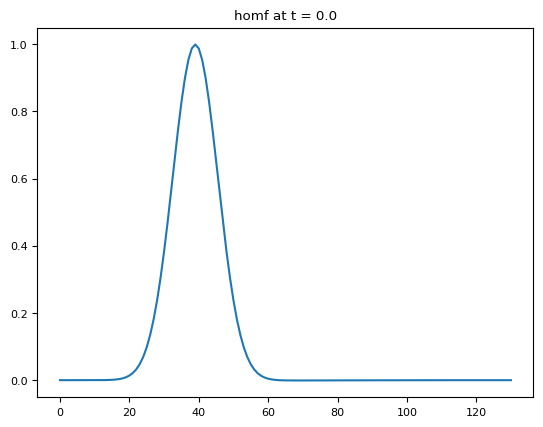

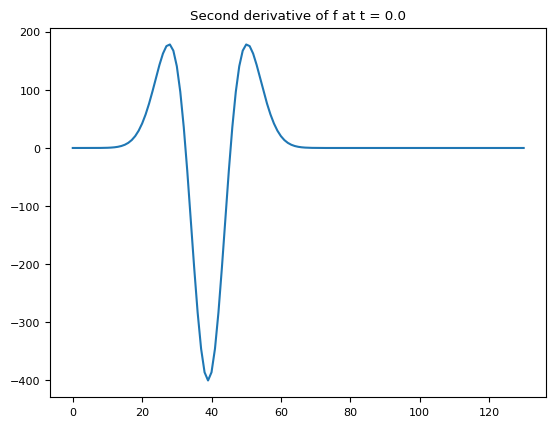

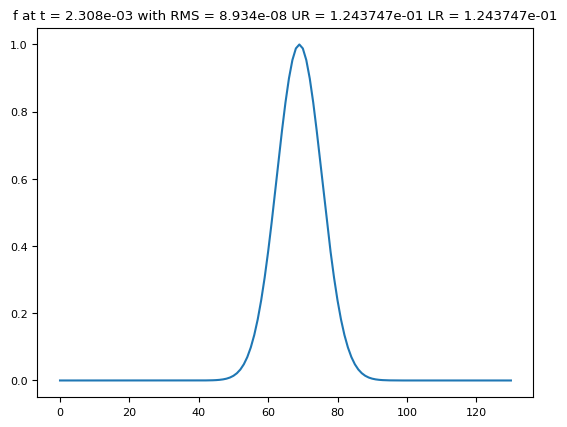

In [326]:

L = 1
N = 131
x, dx = computeX(0, L, N)
v = 100
dt = dx/v**2
print(dt)
r = (v * dt)**2
t = 0.0
BC = PERIODIC
mode = MNONIC_PERIODIC
derivative_mode = FOURTH_ORDER
h = dx 
bc_boundary = 6
fd_boundary = 0

run(L, N, x, dx, dt, v, r, t, BC, mode, derivative_mode, h, bc_boundary, fd_boundary)

## Solving Schrödinger

In [10]:

def get_x_sin_type_1(L, N):
    dx = L/N
    xx = np.linspace(0, L, N+2)[1:-1]
    return xx

def get_x_sin_type_2(L, N):
    dx = L/N
    xx = np.linspace(0+dx/2, L-dx/2, N)
    return xx

def get_x_sin_type_3(L, N):
    dx = L/N
    xx = np.linspace(0+dx/2, L-dx/2, N)
    return xx

def get_x_sin_type_4(L, N):
    dx = L/N
    xx = np.linspace(0+dx/2, L-dx/2, N)
    return xx

def get_x_cos_type_1(L, N):
    dx = L/N
    xx = np.linspace(0+dx/2, L-dx/2, N)
    return xx

def get_x_cos_type_2(L, N):
    dx = L/N
    xx = np.linspace(0+dx/2, L-dx/2, N)
    return xx

def get_x_cos_type_3(L, N):
    dx = L/N
    xx = np.linspace(0+dx/2, L-dx/2, N)
    return xx

def get_x_cos_type_4(L, N):
    dx = L/N
    xx = np.linspace(0+dx/2, L-dx/2, N)
    return xx



def get_k_sin_1(L, N):
    k_sin = np.pi / (L) * np.arange(1, N+1)
    return k_sin

def get_k_sin_2(L, N):
    k_sin = np.pi / (L) * np.arange(1, N+1)
    return k_sin

def get_k_sin_3(L, N):
    k_sin = np.pi / (L) * np.arange(1, N+1)
    return k_sin

def get_k_sin_4(L, N):
    k_sin = np.pi / (L) * np.arange(1, N+1)
    return k_sin


In [102]:



def get_x_fft(L, N):
    dx = L/N
    xx = np.linspace(0 , L , N + 1)[0:N]
    return xx

def get_k_cos(L, N):
    k_cos = np.pi / (L) * np.arange(0, N  )
    return k_cos

def get_k_sin(L, N):
    k_sin = np.pi / (L) * np.arange(1, N+1)
    return k_sin

def get_k_fft(L, N):
    k_fft = 2 * np.pi / (L) * np.arange( - N/2, N/2 )
    k_fft = np.fft.ifftshift(k_fft)
    return k_fft



def sin_derivative(psi, k_cos):
    psihat = scipy.fft.dst(psi, type = 2)
    psihat = np.roll(psihat, 1)
    psihat[0] = 0
    psihat = psihat * k_cos
    psi = scipy.fft.idct(psihat, type = 2)
    return psi


def cos_derivative(psi, k_sin):
    psihat = scipy.fft.dct(psi, type = 2)
    psihat = np.roll(psihat,-1)
    psihat[-1] = 0
    psihat = - psihat * k_sin
    psi = scipy.fft.idst(psihat, type = 2)
    return psi 

def fft_derivative(psi, k_fft):
    psihat = scipy.fft.fft(psi)
    psihat = psihat * k_fft * 1j
    psi = scipy.fft.ifft(psihat)
    return psi 

def sin_dderivative(psi, k_sin):
    psihat = scipy.fft.dst (psi   , type = 2)
    psihat = - psihat * k_sin**2
    psi    = scipy.fft.idst(psihat, type = 2)
    return psi

def cos_dderivative(psi, k_cos):
    psihat = scipy.fft.dct (psi   , type = 2)
    psihat = - psihat * k_cos**2
    psi    = scipy.fft.idct(psihat, type = 2)
    return psi

    
def fft_dderivative(psi, k_fft):
    psihat = scipy.fft.fft(psi)
    psihat = - psihat * k_fft**2
    psi = scipy.fft.ifft(psihat)
    return psi 

def sigma1_func(x, sigma0, delta):
    return sigma0 * ( x + delta ) ** 2


def dsigma1_func(x, sigma0, delta):
    return 2 * sigma0 *  ( x + delta )


def sigma2_func(x, sigma0, delta):
    return sigma0 * ( x + delta ) ** 3


def dsigma2_func(x, sigma0, delta):
    return 3 * sigma0 *  ( x + delta ) ** 2


def sigma3_func(x, sigma0, delta):
    return - sigma0 / x 


def dsigma3_func(x, sigma0, delta):
    return sigma0 / x**2 


def sigma4_func(x, sigma0, delta):
    return sigma0 / x**2


def dsigma4_func(x, sigma0, delta):
    return (-2) * sigma0 / x**3


def sigma5_func(x, sigma0, delta):
    return - sigma0 / x - sigma0 / delta


def dsigma5_func(x, sigma0, delta):
    return sigma0 / x**2


def sigma6_func(x, sigma0, delta):
    return sigma0 / x**2 - sigma0 / delta**2


def dsigma6_func(x, sigma0, delta):
    return (-2) * sigma0 / x**3

sigma_funcs  = [ sigma1_func,  sigma2_func,  sigma3_func,  sigma4_func,  sigma5_func,  sigma6_func]
dsigma_funcs = [dsigma1_func, dsigma2_func, dsigma3_func, dsigma4_func, dsigma5_func, dsigma6_func]

def S_func(x, L0_phys, L0_PLM, L1_phys, L1_PLM, sigma0, delta, sigma_func, gamma = np.pi/4):
    y = np.ones(x.shape, complex)


    y[x <= L0_phys] = 1 + np.exp(1j * gamma) * sigma_func(-np.abs(x[x <= L0_phys] - L0_PLM), sigma0, delta)
    y[x >= L1_phys] = 1 + np.exp(1j * gamma) * sigma_func(-np.abs(x[x >= L1_phys] - L1_PLM), sigma0, delta)
    return y

def dS_func(x, L0_phys, L0_PLM, L1_phys, L1_PLM, sigma0, delta, dsigma_func, gamma = np.pi/4):
    y = np.zeros(x.shape, complex)

    y[x <= L0_phys] = np.exp(1j * gamma) * (-1) * np.sign(x[x <= L0_phys] - L0_PLM) * dsigma_func(-np.abs(x[x <= L0_phys] - L0_PLM), sigma0, delta)
    y[x >= L1_phys] = np.exp(1j * gamma) * (-1) * np.sign(x[x >= L1_phys] - L1_PLM) * dsigma_func(-np.abs(x[x >= L1_phys] - L1_PLM), sigma0, delta)
    return y

from chebfftPy import chebfft

def cheby_exgrid(N,a,b):
    i=np.linspace(0,N,N+1)
    return (b-a)/2.*(-np.cos(i*np.pi/N))+(b+a)/2.0

def cheby_poly(x,n):
    T0 = 1.0
    T1 = x
    if n == 0:
        return  T0
    elif n == 1:
        return  T1
    elif n > 1:
        for i in range(n-1):
            T = 2*x*T1-T0 
            T0 = T1
            T1 = T
        return T

def cheby_coeff(x,y,N):
    a = []
    y[0] *= 0.5
    y[N] *= 0.5

    x_chebgrid = cheby_exgrid(N,-1.0,1.0)
    print(x,x_chebgrid)
    for j in range(N+1):
        sum = 2.0 / N  * np.sum(y*cheby_poly(x_chebgrid,j))
        a.append(sum)

    y[0] /= 0.5
    y[N] /= 0.5
    return a

def cheby_interp(x,coeff,N,a,b):

    x_chebgrid = ( 2.0 * x - a  - b ) / ( b-a);
    sum  = coeff[0]*cheby_poly(x_chebgrid,0) * 0.5    
    for j in range(1,N-1):
        sum += coeff[j]*cheby_poly(x_chebgrid,j)
    sum += coeff[N]*cheby_poly(x_chebgrid,N) * 0.5
    return sum
'''
f = np.loadtxt('test')[:,[0,1]]

plt.plot(f)
plt.show()
N = np.shape(f)[0]-1

xx     = cheby_exgrid(40,f[0,0],f[-1,0])
coeff  = cheby_coeff (f[:,0],f[:,1],N)
interp = cheby_interp(xx,coeff,N,f[0,0],f[-1,0])

print( cheby_interp(0.504897,coeff,N,f[0,0],f[-1,0]))
plt.plot(f[:,0],f[:,1],'>',xx,interp,'.')
plt.show()
'''
# test it with sin(x)
# a = 1.
# b = 2.
# x = cheby_exgrid(N,a,b)
# f = np.sin(5.*x)
# xx = np.linspace(a,b,11)

# coeff = cheby_coeff(x,f,N)
# interp =  cheby_interp(xx,coeff,N,a,b)
# plt.plot(x,f,'-',xx,interp,'.')
# plt.show()


"\nf = np.loadtxt('test')[:,[0,1]]\n\nplt.plot(f)\nplt.show()\nN = np.shape(f)[0]-1\n\nxx     = cheby_exgrid(40,f[0,0],f[-1,0])\ncoeff  = cheby_coeff (f[:,0],f[:,1],N)\ninterp = cheby_interp(xx,coeff,N,f[0,0],f[-1,0])\n\nprint( cheby_interp(0.504897,coeff,N,f[0,0],f[-1,0]))\nplt.plot(f[:,0],f[:,1],'>',xx,interp,'.')\nplt.show()\n"

### Spectral differentiation

#### Making it periodic

In [ ]:


errors1 = []
errors2 = []
errors3 = []

#The test problem 
L0 = -1.5
L1 = 1.5
L  = L1- L0
q = np.pi * np.pi 

def f(x):
    return np.sin(q * x)
def df(x):
    return q * np.cos(q * x) 
def ddf(x):
    return -q**2 * np.sin(q * x) 


resolutions = 2**np.arange(5, 6)
for N in resolutions: 
    # Get the job done with a continuous function 
    xx    = get_x_fft(L, N) + L0 
    dx    = xx[1] - xx[0]
    k_fft = get_k_fft(L, N)

    plt.plot(xx, hompsi)
    plt.plot(xx + L, hompsi)
    plt.plot(xx + 2*L, hompsi)
    plt.show()
    hompsi = hompsi
    psihat = scipy.fft.fft (hompsi)
    plt.plot(psihat)
    plt.show()
    psihat = - psihat * k_fft**2
    num    = scipy.fft.ifft(psihat) + B 
    ana    = ddf(xx)

    plt.plot(num, label="rec")
    plt.plot(ana, label="ana")
    plt.legend()
    plt.show()

    N_frac = int(len(num)/4)
    errors1.append(np.mean(np.abs(num-ana)[N_frac:-N_frac]))

[-1.5     -1.40625 -1.3125  -1.21875 -1.125   -1.03125 -0.9375  -0.84375
 -0.75    -0.65625 -0.5625  -0.46875 -0.375   -0.28125 -0.1875  -0.09375
  0.       0.09375  0.1875   0.28125  0.375    0.46875  0.5625   0.65625
  0.75     0.84375  0.9375   1.03125  1.125    1.21875  1.3125   1.40625]


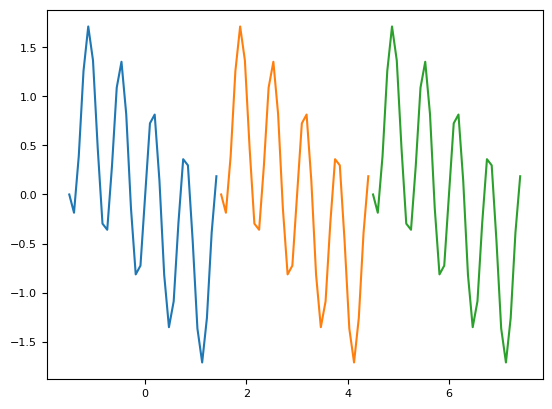

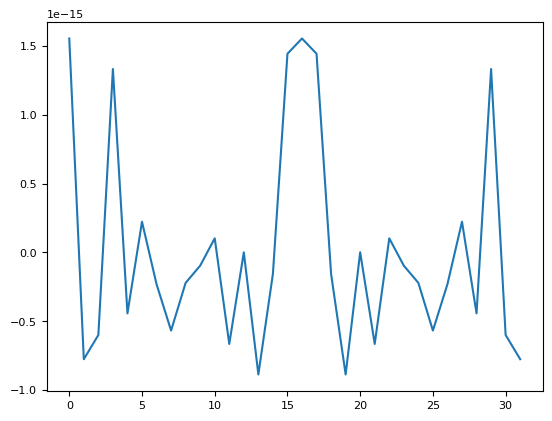

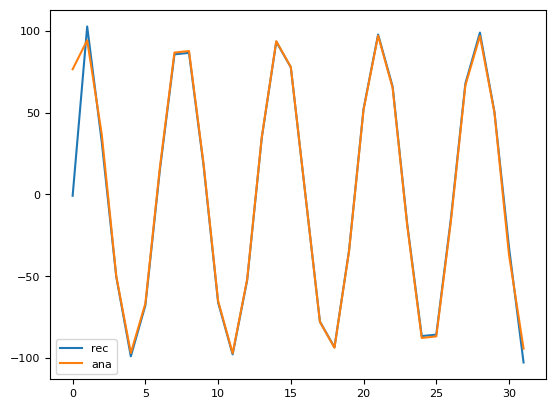

[-1.5      -1.453125 -1.40625  -1.359375 -1.3125   -1.265625 -1.21875
 -1.171875 -1.125    -1.078125 -1.03125  -0.984375 -0.9375   -0.890625
 -0.84375  -0.796875 -0.75     -0.703125 -0.65625  -0.609375 -0.5625
 -0.515625 -0.46875  -0.421875 -0.375    -0.328125 -0.28125  -0.234375
 -0.1875   -0.140625 -0.09375  -0.046875  0.        0.046875  0.09375
  0.140625  0.1875    0.234375  0.28125   0.328125  0.375     0.421875
  0.46875   0.515625  0.5625    0.609375  0.65625   0.703125  0.75
  0.796875  0.84375   0.890625  0.9375    0.984375  1.03125   1.078125
  1.125     1.171875  1.21875   1.265625  1.3125    1.359375  1.40625
  1.453125]


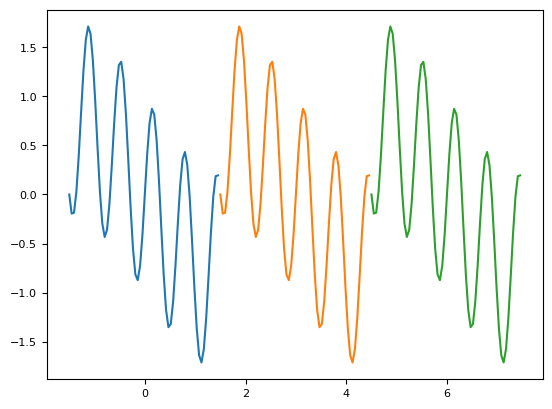

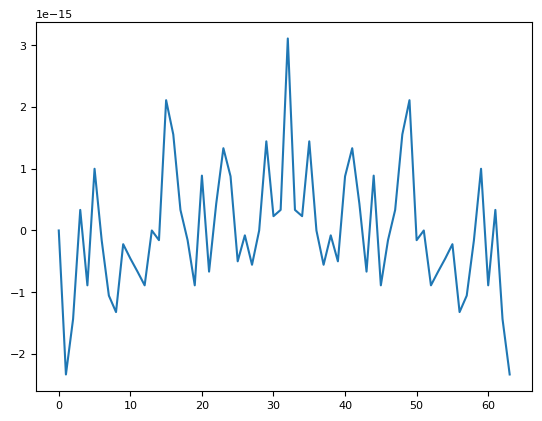

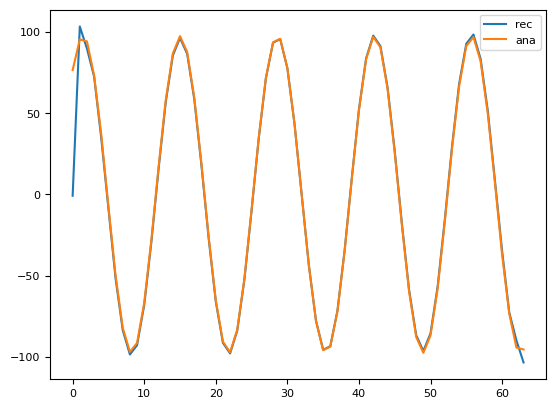

[-1.5       -1.4765625 -1.453125  -1.4296875 -1.40625   -1.3828125
 -1.359375  -1.3359375 -1.3125    -1.2890625 -1.265625  -1.2421875
 -1.21875   -1.1953125 -1.171875  -1.1484375 -1.125     -1.1015625
 -1.078125  -1.0546875 -1.03125   -1.0078125 -0.984375  -0.9609375
 -0.9375    -0.9140625 -0.890625  -0.8671875 -0.84375   -0.8203125
 -0.796875  -0.7734375 -0.75      -0.7265625 -0.703125  -0.6796875
 -0.65625   -0.6328125 -0.609375  -0.5859375 -0.5625    -0.5390625
 -0.515625  -0.4921875 -0.46875   -0.4453125 -0.421875  -0.3984375
 -0.375     -0.3515625 -0.328125  -0.3046875 -0.28125   -0.2578125
 -0.234375  -0.2109375 -0.1875    -0.1640625 -0.140625  -0.1171875
 -0.09375   -0.0703125 -0.046875  -0.0234375  0.         0.0234375
  0.046875   0.0703125  0.09375    0.1171875  0.140625   0.1640625
  0.1875     0.2109375  0.234375   0.2578125  0.28125    0.3046875
  0.328125   0.3515625  0.375      0.3984375  0.421875   0.4453125
  0.46875    0.4921875  0.515625   0.5390625  0.5625     0.585

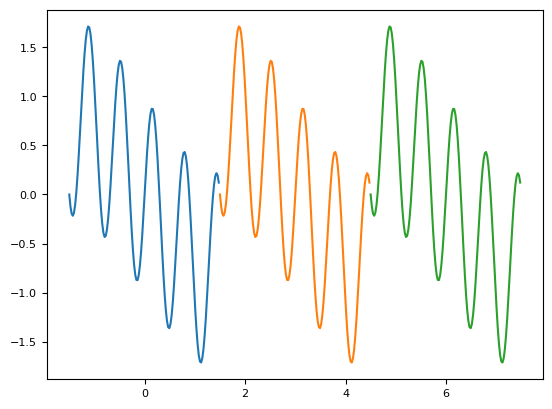

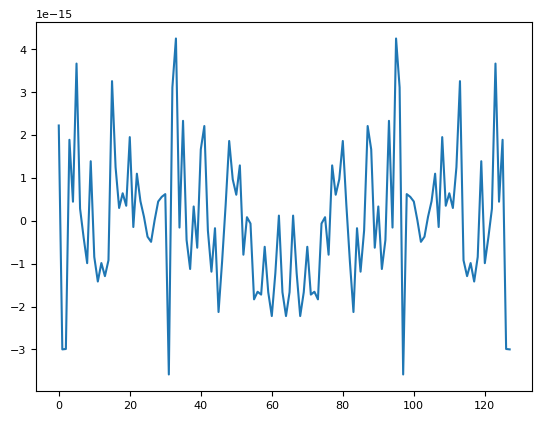

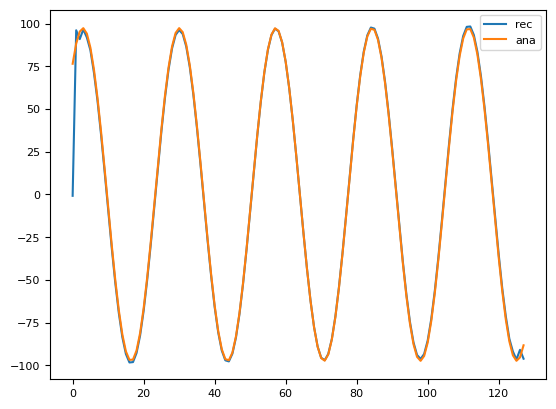

[-1.5        -1.48828125 -1.4765625  -1.46484375 -1.453125   -1.44140625
 -1.4296875  -1.41796875 -1.40625    -1.39453125 -1.3828125  -1.37109375
 -1.359375   -1.34765625 -1.3359375  -1.32421875 -1.3125     -1.30078125
 -1.2890625  -1.27734375 -1.265625   -1.25390625 -1.2421875  -1.23046875
 -1.21875    -1.20703125 -1.1953125  -1.18359375 -1.171875   -1.16015625
 -1.1484375  -1.13671875 -1.125      -1.11328125 -1.1015625  -1.08984375
 -1.078125   -1.06640625 -1.0546875  -1.04296875 -1.03125    -1.01953125
 -1.0078125  -0.99609375 -0.984375   -0.97265625 -0.9609375  -0.94921875
 -0.9375     -0.92578125 -0.9140625  -0.90234375 -0.890625   -0.87890625
 -0.8671875  -0.85546875 -0.84375    -0.83203125 -0.8203125  -0.80859375
 -0.796875   -0.78515625 -0.7734375  -0.76171875 -0.75       -0.73828125
 -0.7265625  -0.71484375 -0.703125   -0.69140625 -0.6796875  -0.66796875
 -0.65625    -0.64453125 -0.6328125  -0.62109375 -0.609375   -0.59765625
 -0.5859375  -0.57421875 -0.5625     -0.55078125 -0

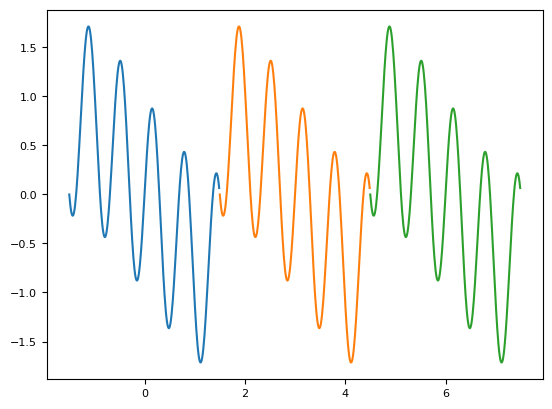

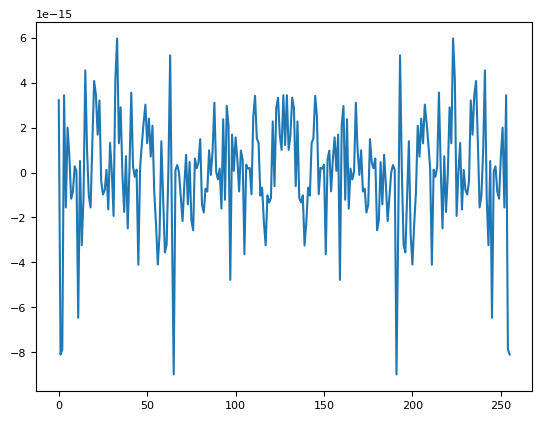

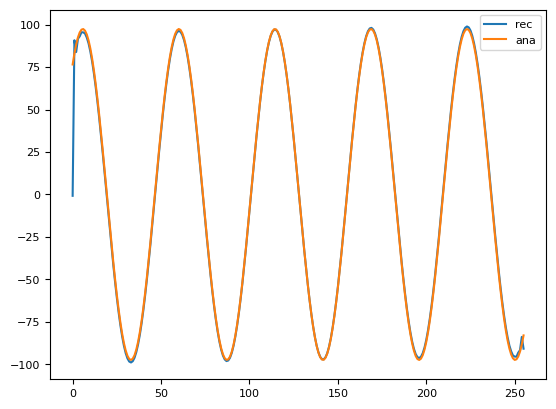

[-1.5        -1.49414062 -1.48828125 -1.48242188 -1.4765625  -1.47070312
 -1.46484375 -1.45898438 -1.453125   -1.44726562 -1.44140625 -1.43554688
 -1.4296875  -1.42382812 -1.41796875 -1.41210938 -1.40625    -1.40039062
 -1.39453125 -1.38867188 -1.3828125  -1.37695312 -1.37109375 -1.36523438
 -1.359375   -1.35351562 -1.34765625 -1.34179688 -1.3359375  -1.33007812
 -1.32421875 -1.31835938 -1.3125     -1.30664062 -1.30078125 -1.29492188
 -1.2890625  -1.28320312 -1.27734375 -1.27148438 -1.265625   -1.25976562
 -1.25390625 -1.24804688 -1.2421875  -1.23632812 -1.23046875 -1.22460938
 -1.21875    -1.21289062 -1.20703125 -1.20117188 -1.1953125  -1.18945312
 -1.18359375 -1.17773438 -1.171875   -1.16601562 -1.16015625 -1.15429688
 -1.1484375  -1.14257812 -1.13671875 -1.13085938 -1.125      -1.11914062
 -1.11328125 -1.10742188 -1.1015625  -1.09570312 -1.08984375 -1.08398438
 -1.078125   -1.07226562 -1.06640625 -1.06054688 -1.0546875  -1.04882812
 -1.04296875 -1.03710938 -1.03125    -1.02539062 -1

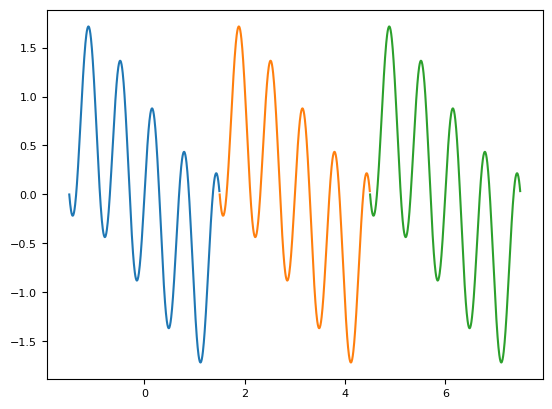

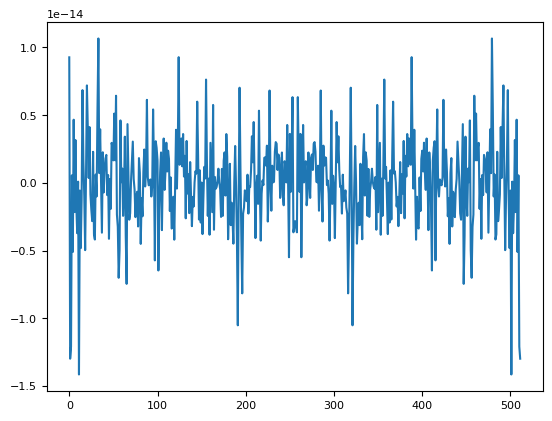

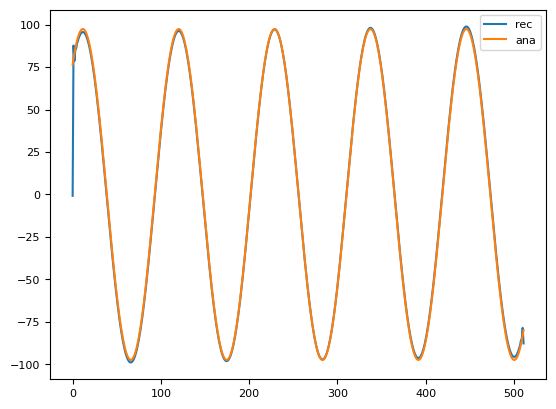

[-1.5        -1.49707031 -1.49414062 ...  1.49121094  1.49414062
  1.49707031]


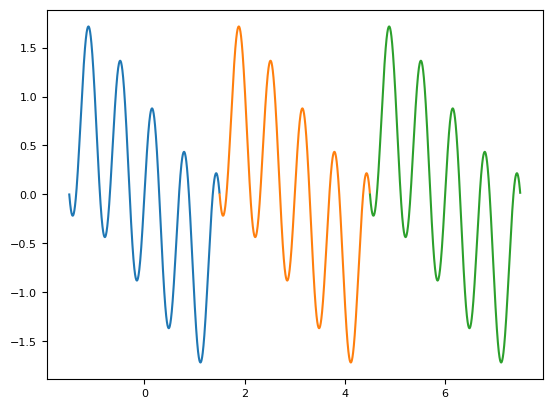

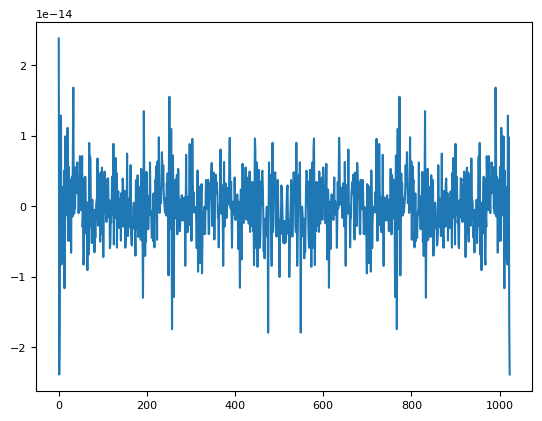

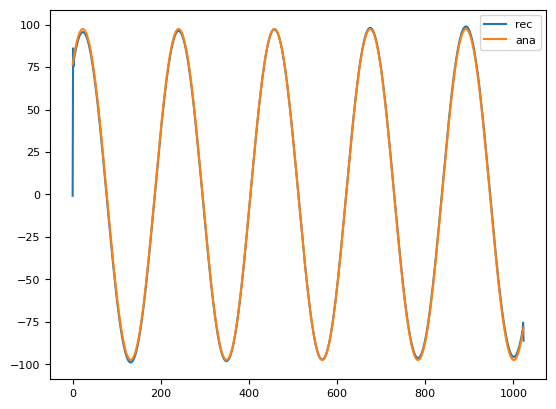

[-1.5        -1.49853516 -1.49707031 ...  1.49560547  1.49707031
  1.49853516]


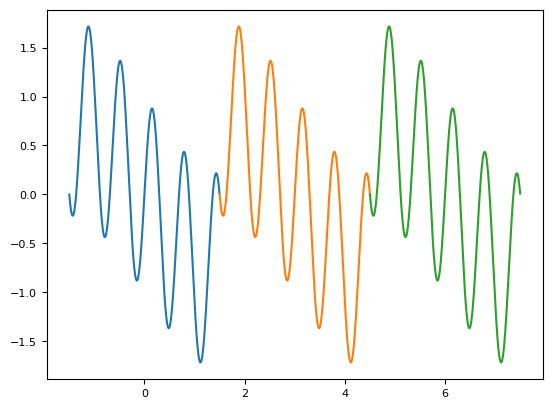

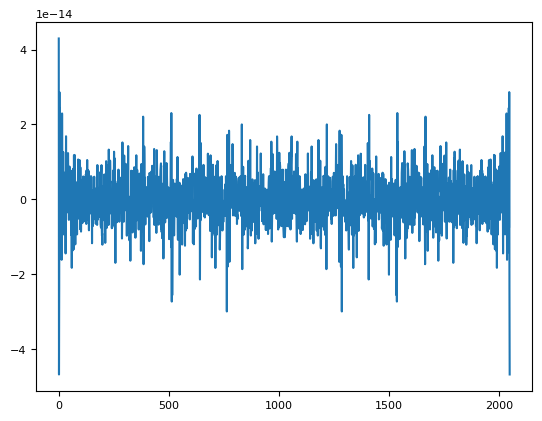

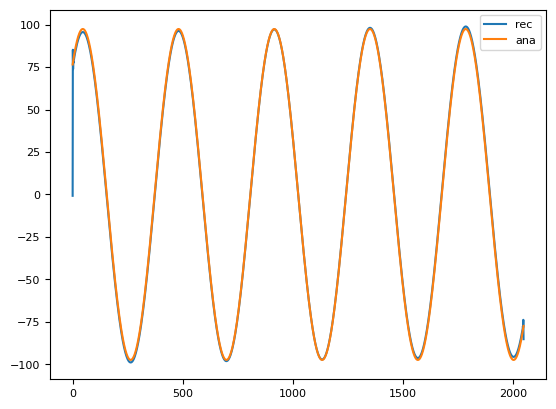

In [88]:


errors1 = []
errors2 = []
errors3 = []

#The test problem 
L0 = -1.5
L1 = 1.5
L  = L1- L0
q = np.pi * np.pi 

def f(x):
    return np.sin(q * x)
def df(x):
    return q * np.cos(q * x) 
def ddf(x):
    return -q**2 * np.sin(q * x) 


resolutions = 2**np.arange(5, 12)
for N in resolutions: 
    # Get the job done with a continuous function 
    xx   = get_x_fft(L, N) + L0 
    print(xx)
    k_fft = get_k_fft(L, N)
    dx   = xx[1] - xx[0]
    psi   = f(xx)
    psi0  = f(L0)
    psi1  = f(L1)
    dpsi0 = df(L0)
    dpsi1 = df(L1)

    poly = scipy.interpolate.CubicHermiteSpline([L0, L1], [psi0, psi1], [0, dpsi1 - dpsi0], axis=0, extrapolate=None)
    B     = poly(xx)
    ddB   = poly(xx, 2)
    hompsi = psi - B
    plt.plot(xx, hompsi)
    plt.plot(xx + L, hompsi)
    plt.plot(xx + 2*L, hompsi)
    plt.show()
    hompsi = hompsi
    psihat = scipy.fft.fft (hompsi)
    plt.plot(psihat)
    plt.show()
    psihat = - psihat * k_fft**2
    num    = scipy.fft.ifft(psihat) + B 
    ana    = ddf(xx)

    plt.plot(num, label="rec")
    plt.plot(ana, label="ana")
    plt.legend()
    plt.show()

    N_frac = int(len(num)/4)
    errors1.append(np.mean(np.abs(num-ana)[N_frac:-N_frac]))

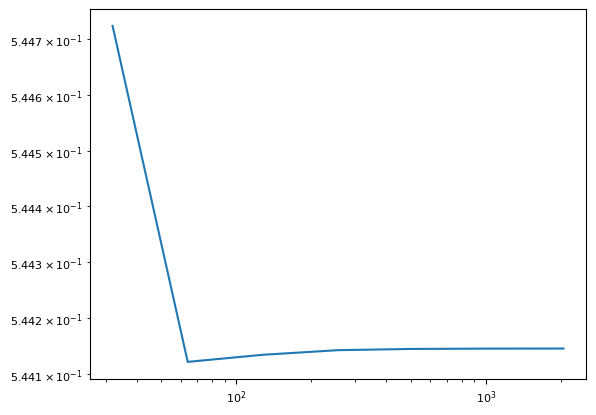

In [89]:
plt.loglog(resolutions, errors1)

#### Making it smooth

In [ ]:


errors1 = []
errors2 = []
errors3 = []


#The test problem 
L0 = -1.3
L1 = 1
L  = L1 - L0
q = np.pi * np.pi

alpha = 1 
def f(x):
    return np.sin(q * x) * np.exp(- alpha * x**2)
def df(x):
    return (q * np.cos(q * x) - alpha * 2*x * np.sin(q * x) ) * np.exp(-alpha * x**2)
def ddf(x):
    return (-q**2 * np.sin(q * x) - alpha * 2* np.sin(q * x) - alpha * 2 * x * q * np.cos(q * x) - 2 * alpha * x ) * np.exp(-alpha * x**2)



resolutions = 2**np.arange(6, 16)
for N in resolutions: 


    # Get the job done with a continuous function 
    xx   = get_x_sin_type_1(L, N) + L0
    dx   = xx[1] - xx[0]
    xl = np.array([xx[0] - dx, *xx, xx[-1] + dx]).flatten()
    
    k_sin = get_k_sin(L, N)

    psi   = f(xx)
    psi0  = f(L0)
    psi1  = f(L1)
    print(psi0, psi1)
    dpsi0 = df(L0)
    dpsi1 = df(L1)

    psil = f(xl) 

    plt.title("psi")
    plt.plot(psi)
    plt.show()

    plt.title(f"psil psi 0 {psil[0]} psi -1 {psil[-1]}")
    plt.plot(psil)
    plt.show()

    poly   = scipy.interpolate.CubicHermiteSpline([L0, L1], [psi0, psi1], [0, -dpsi1 + dpsi0], axis=0, extrapolate=None)
    B      = poly(xx)
    ddB    = poly(xx, 2)
    hompsi = psi - B
    hompsil = psil - poly(xl)
    d00 = (hompsil[1] - hompsil[0])/dx
    d10 = (hompsil[-1] - hompsil[-2])/dx

    plt.title("B1")
    plt.plot(B)
    plt.show()


    plt.title(f"B1 hompsi 0 {hompsil[0]} -1 {hompsil[-1]} d0 {d00} d-1 {d10}")
    plt.plot(xl, hompsil)
    plt.plot(xl + L, hompsil)
    plt.plot(xl + 2*L, hompsil)
    plt.show()



    psihat = scipy.fft.dst (hompsi, type = 1)
    psihat = - psihat * k_sin**2
    num    = scipy.fft.idst(psihat, type = 1)
    ana    = ddf(xx)

    N_frac = int(len(num)/4)
    errors1.append(np.mean(np.abs(num-ana)[N_frac:-N_frac]))


    C2 = (psi1 - psi0)/(L1 - L0)
    B2 = (psi0 + C2 * (xl - L0))
    hompsil = psil - B2
    C2 = (psi1 - psi0)/(L1 - L0)
    B  = (psi0 + C2 * (xx - L0))
    hompsi = psi - B

    d01 = (hompsil[1] - hompsil[0])/dx
    d11 = (hompsil[-1] - hompsil[-2])/dx

    plt.title("B2")
    plt.plot(B2)
    plt.show()


    plt.title(f"B2 hompsi 0 {hompsil[0]} -1 {hompsil[-1]} d0 {d01} d-1 {d11}")
    plt.plot(xl, hompsil)
    plt.plot(xl + L, hompsil)
    plt.plot(xl + 2*L, hompsil)
    plt.show()


    psihat = scipy.fft.dst (hompsi, type = 1)
    psihat = - psihat * k_sin**2
    num    = scipy.fft.idst(psihat, type = 1)
    ana    = ddf(xx)

    N_frac = int(len(num)/4)
    errors2.append(np.mean(np.abs(num-ana)[N_frac:-N_frac]))

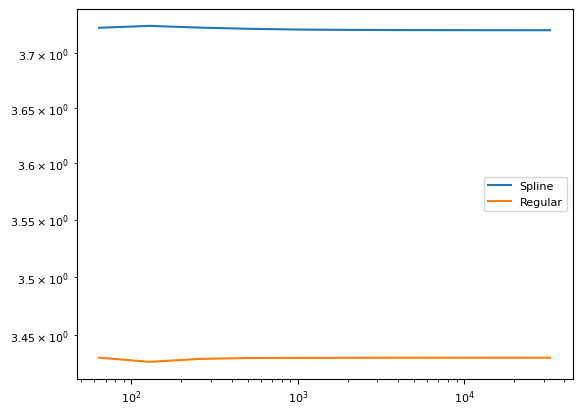

In [120]:
plt.loglog(resolutions, errors1, label = "Spline")
plt.loglog(resolutions, errors2, label = "Regular")
plt.legend()
plt.show()

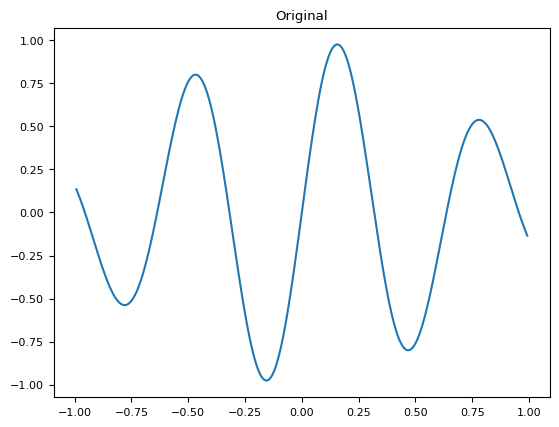

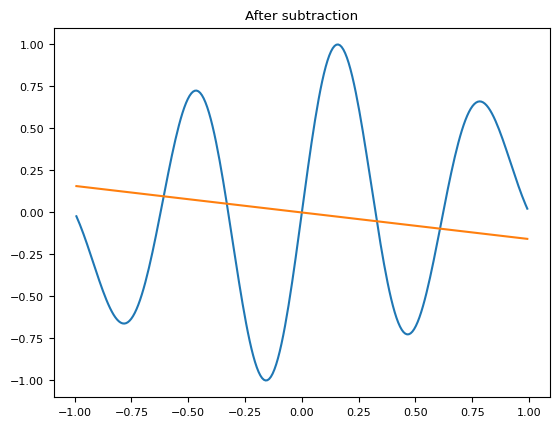

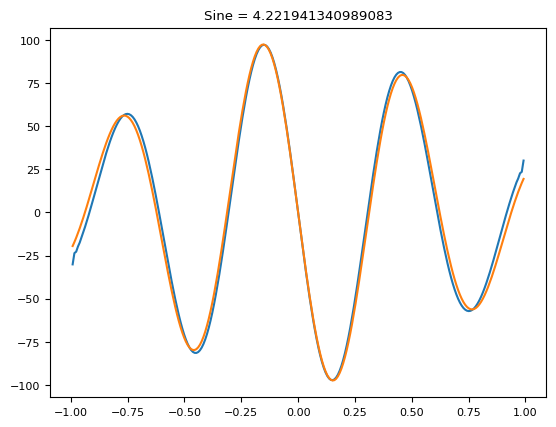

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

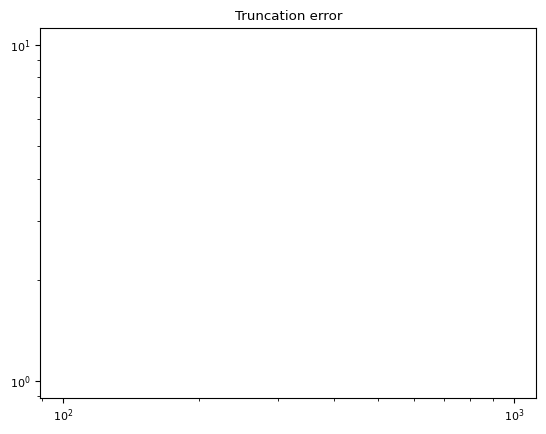

In [142]:


resolutions = 2**np.arange(8, 9)
errors1 = []
errors2 = []
errors3 = []


#The test problem 
L0 = -1
L1 = 1
L  = L1 - L0
q = np.pi * np.pi 
alpha = 1 
def f(x):
    return np.sin(q * x) * np.exp(- alpha * x**2)
def df(x):
    return (q * np.cos(q * x) - alpha * 2*x * np.sin(q * x) ) * np.exp(-alpha * x**2)
def ddf(x):
    return (-q**2 * np.sin(q * x) - alpha * 2* np.sin(q * x) - alpha * 2 * x * q * np.cos(q * x) - 2 * alpha * x ) * np.exp(-alpha * x**2)

for resolution in resolutions:
    N = resolution 

    # Get the job done with a continuous function 
    xx    = get_x_sin_type_1(L, N) + L0 
    k_sin = get_k_sin(L, N)

    psi   = f(xx)
    psi0  = f(L0)
    psi1  = f(L1)
    dpsi0 = df(L0)
    dpsi1 = df(L1)


    plt.title(f"Original")
    plt.plot(xx, psi)
    plt.show()

    C = (psi1 - psi0)/(L1 - L0)
    B = (psi0 + C * (xx - L0))
    hompsi = (psi - B)


    plt.title(f"After subtraction")
    plt.plot(xx, hompsi, label="homogenised")
    plt.plot(xx, B, label="Linear")
    plt.show()
    
    psihat = scipy.fft.dst (hompsi, type = 1)
    psihat = - psihat * k_sin**2
    num    = scipy.fft.idst(psihat, type = 1)
    ana    = ddf(xx) 
    plt.title(f"Sine = {np.mean(np.abs(ana -num))}")
    plt.plot(xx, num)
    plt.plot(xx, ana)
    plt.show()


    errors1.append(np.mean(np.abs(ana -num)[10:-10]))

    ## Get the job done with a function with continuous first derivative 
    #xx    = get_x_sin_type_1(L, N) + L0 
    #dx    = xx[1] - xx[0]
    #k_sin = get_k_sin(L, N)
#
    #psi   = f(xx)
    #psi0  = f(L0)
    #psi1  = f(L1)
    #dpsi0 = df(L0)
    #dpsi1 = df(L1)
#
    #poly = scipy.interpolate.CubicHermiteSpline([L0, L1], [psi0, psi1], [0, dpsi1 - dpsi0], axis=0, extrapolate=None)
    #B     = poly(xx)
    #ddB   = poly(xx, 2)
    #hompsi2 = psi - B
#
    #plt.title("Hompsis")
    #plt.plot(xx        , hompsi, c = "r", label = "Linear")
    #plt.plot(xx + L    , hompsi, c = "r", )
    #plt.plot(xx + 2 * L, hompsi, c = "r", )
    #plt.plot(xx        , hompsi2, c = "k", label = "Spline")
    #plt.plot(xx + L    , hompsi2, c = "k")
    #plt.plot(xx + 2 * L, hompsi2, c = "k")
    #plt.legend()
    #plt.show()
#
    #psihat = scipy.fft.dst (hompsi2, type = 2)
    #psihat = - psihat * k_sin**2
    #num    = scipy.fft.idst(psihat, type = 2) + ddB
    #plt.title("ddB")
    #plt.plot(ddB)
    #plt.show()
    #ana    = ddf(xx) 
#
 #
    #plt.title(f"Sine 2 = {np.mean(np.abs(ana -num))}")
    #plt.plot(xx, num)
    #plt.plot(xx, ana)
    #plt.show()
    #errors2.append(np.mean(np.abs(ana -num)[10:-10]))
#
    ## Get the job done using Chebyshev
    #xx = np.cos(np.arange(0,N+1)*np.pi/N)
    #psi   = f(xx).astype(np.float128)
    #num  = chebfft(chebfft(psi))[2:-2]
    #ana  = ddf(xx)[2:-2]
    #errors3.append(np.mean(np.abs(ana -num)))
#
    ## Get the job done by making everything periodic
    #xx    = get_x_fft(L, N) + L0
    #dx    = xx[1] -xx[0]
    
plt.title(f"Truncation error")
plt.loglog(resolutions, errors1, label="Sine ( fcont)")
plt.loglog(resolutions, errors2, label="Sine (df cont)")
plt.loglog(resolutions, errors3, label="Chebyshev")
plt.loglog(resolutions, 1/2**(np.arange(len(resolutions))), label="1st order")
plt.loglog(resolutions, 1/2**(4 * np.arange(len(resolutions))), label="4th order")
plt.loglog(resolutions, 1/2**(8 * np.arange(len(resolutions))), label="8th order")
plt.legend()
    



/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


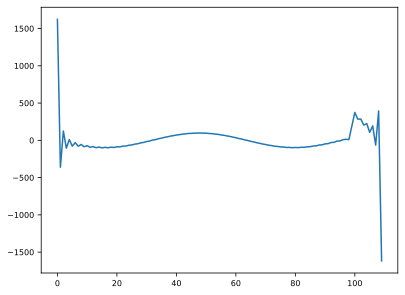

In [267]:
N = 100
xx    = get_x_fft(1, N)
dx    = xx[1] -xx[0]
Ngh   = 10
Ltot  = 1 + Ngh * dx
Ntot  = N + Ngh
xx_larger = get_x_fft(Ltot, Ntot)
psi  = np.zeros(xx_larger.shape)
psi[:len(xx)] = f(xx)
poly = scipy.interpolate.CubicHermiteSpline([xx[-1], xx_larger[-1]], [f(xx[-1]), f(xx[0])], [df(xx[-1]), df(xx[0])], axis=0, extrapolate=None)
psi[len(xx):] = poly(xx_larger[len(xx):])

k = get_k_fft(Ltot, Ntot)
psihat = scipy.fft.fft(psi)
psihat = psihat * (-1) * k**2
ddpsi    = scipy.fft.ifft(psihat)

plt.plot(ddpsi)

In [247]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from chebfftPy import chebfft
from numpy import pi,linspace,sin,cos,exp,round,zeros,arange,real, flipud
from numpy.fft import fft,ifft
from matplotlib.pyplot import figure,subplot,plot,grid,title,axis

figure(figsize=(10,12))
plot_count = 1

for N in [10,20,1000]:
    xx = linspace(-1.0,1.0,100)
    ff = np.sin(np.pi * np.pi * xx)
    x = cos(arange(0,N+1)*pi/N)
    f = exp(x)*sin(5*x)
    print(f[0], f[-1])
    error = np.mean(np.abs(chebfft(f) - exp(x)*(sin(5*x)+5*cos(5*x))))
    print(error)



-2.6066264306850795 0.35276852628880606
0.007491079071890364
-2.6066264306850795 0.35276852628880606
2.800846908898723e-10
-2.6066264306850795 0.35276852628880606
7.049998566742567e-13


<Figure size 1000x1200 with 0 Axes>

[1.13326243 1.04895355 1.02085058 1.0067991  1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.0067991  1.02085058 1.04895355 1.13326243]


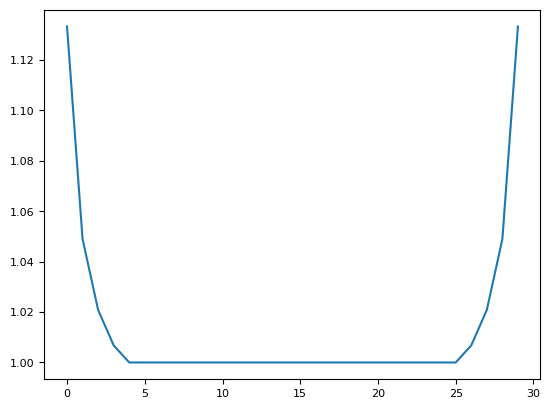

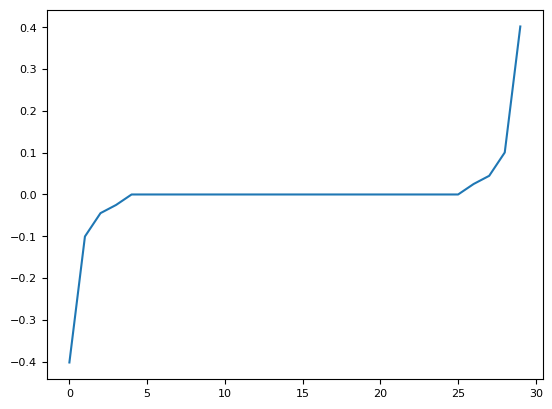

In [ ]:
x = np.linspace(-3, 10, 30 + 2)[1:-1]
y = np.real(S_func(x, -1, -3, 8, 10, 1e-1, 2, sigma5_func))
print(y)
plt.plot(np.real(S_func(x, -1, -3, 8, 10, 1e-1, 2, sigma5_func)))
plt.show()
plt.plot(np.real(dS_func(x, -1, -3, 8, 10, 1e-1, 2, dsigma5_func)))

### The schemes

In [184]:
poly = scipy.interpolate.make_interp_spline()

array([2, 3, 4])

In [328]:

import numpy as np

import src.fd as fd
import src.schemes as schemes
import src.phase_schemes as ps
import src.wave_schemes as ws 
import src.config as config 
import src.animation as animation 

import matplotlib.pyplot as plt 
import scipy


import numpy as np

import src.fd as fd
import src.schemes as schemes
import src.phase_schemes as ps
import src.wave_schemes as ws 
import src.config as config 
import src.animation as animation 

import matplotlib.pyplot as plt 
import scipy

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]
        self.replaceBoundary = config["replaceBoundary"]


        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar = config["hbar"]
        self.m    = config["m"]
        self.eta  = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]


        if (self.G == 0) and self.useCosmology:
            raise ValueError(
                "Gravity required in expanding universe! Set config[Gravity] != 0."
            )

        if (self.G != 0) and not self.usePeriodicBC:
            raise ValueError(
                "Gravity only supported for periodic boundary conditions."
            )
        
        self.psi     = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.potential = np.zeros(self.psi.shape, dtype=np.float128)




    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi):
        if self.replaceBoundary:
            f = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
            psi[self.boundary] = f[self.boundary]

        self.psi0 = self.generateIC(self.Ll, self.dx, self.t, self.m, self.hbar)
        self.psi1 = self.generateIC(self.Lh, self.dx, self.t, self.m, self.hbar)
        
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS
    

    #Implement first to fourth order TVD-RK integrator by default
    #Can be overwritten in children classes to implement different time integration
    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.fields)

        un = self.kick1(self.fields, dt)

        if self.outputTimestep:
            print(f"t = {self.t:.7f} dt = {dt:.7f} a = {self.getScaleFactor():.7f} ")

        if self.timeOrder == 1:
            un = un + 1 / 1 * self.getUpdatedFields(self.t, dt, un)

        elif self.timeOrder == 2:
            u1 = un + self.getUpdatedFields(self.t, dt, un)
            un = 1 / 2 * un + 1 / 2 * u1 + self.getUpdatedFields(self.t + dt, 1/2 * dt, u1)

        elif self.timeOrder == 3:
            u1 = un + self.getUpdatedFields(self.t, dt, un)
            u2 = 3 / 4 * un + 1 / 4 * u1 +  self.getUpdatedFields(self.t +       dt, 1/4 * dt, u1)
            un = 1 / 3 * un + 2 / 3 * u2 + self.getUpdatedFields (self.t + 0.5 * dt, 2/3 * dt, u2)

        elif self.timeOrder == 4:
            u1 = un + self.getUpdatedFields(self.t, 0.39175222700392 * dt, un)
            u2 = (
                0.44437049406734 * un
                + 0.55562950593266 * u1
                + self.getUpdatedFields(self.t + 0.39175222700392 * dt, 0.36841059262959 * dt, u1)
            )
            u3 = (
                0.62010185138540 * un
                + 0.37989814861460 * u2
                + self.getUpdatedFields(self.t + 0.58607968896780 * dt, 0.25189177424738 * dt, u2)
            )
            u4 = (
                0.17807995410773 * un
                + 0.82192004589227 * u3
                + self.getUpdatedFields(self.t + 0.47454236302687 * dt, 0.54497475021237 * dt, u3)
            )
            un = (
                0.00683325884039 * un
                + 0.51723167208978 * u2
                + 0.12759831133288 * u3
                + self.getUpdatedFields(self.t + 0.47454236302687 * dt, 0.08460416338212 * dt, u3)
                + 0.34833675773694 * u4
                + self.getUpdatedFields(self.t + 0.93501063100924 * dt, 0.22600748319395 * dt, u4)
            )
        elif self.timeOrder == 5:
            u1 = un + self.getUpdatedFields(self.t           , 0.5 * dt, un)
            un = un + self.getUpdatedFields(self.t + 0.5 * dt, 1.0 * dt, u1)
        else:
            raise ValueError("Invalid time order")

        self.fields = self.kick2(un, dt)


        self.t += dt * self.getScaleFactor() ** 2

def evolveWavefunction(p, dx, Coeff1, T1, debug = False):
    k = computeK(p, dx, T1) 

    if   T1 <= DCT4:
        p_hat = sp.fft.dct(p, type = T1)
    elif T1 <= DST4: 
        p_hat = sp.fft.dst(p, type = T1 - 4)
    else:
        p_hat = sp.fft.fft(p) 

    if debug:
        plt.title("p_hat") 
        plt.plot(p_hat.real, label="real")
        plt.plot(p_hat.imag, label="imag")
        plt.legend()
        plt.show()

    p_hat   = np.exp(1.0j * Coeff1 * (-k**2)) * p_hat

    if   T1 <= DCT4:
        pn = sp.fft.idct(p_hat, type = T1)
    elif T1 <= DST4: 
        pn = sp.fft.idst(p_hat, type = T1 - 4)
    else:
        pn = sp.fft.ifft(p_hat) 

    if debug:
        plt.title("ddp") 
        plt.plot(pn.real, label="real")
        plt.plot(pn.imag, label="imag")
        plt.legend()
        plt.show()

    return pn


class DFTScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.derivative_mode = config["mode"]           
        self.mode            = config["derivative_mode"]
        self.BC              = config["BC"]             
        self.fd_boundary     = config["fd_boundary"]

        if self.BC == PERIODIC:
            if self.totalN % 2 == 0:
                raise ValueError("Periodic boundary conditions required uneven number of points!") 

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi)

        #Aliases
        x           = self.grid[0]
        psi         = self.psi
        dx          = self.dx
        BC          = self.BC 
        fd_boundary = self.fd_boundary
        N           = len(psi)
        
        #Boundary for finite difference stencils
        lb =   fd_boundary
        rb = - fd_boundary 

        #Taylor expansion coefficients of e^{dt * eta/2 * del_x**2}
        Coeff1   = 1/2  * dt * self.eta
        Coeff2   = 1/2  * Coeff1**2
        Coeff3   = 1/6  * Coeff1**3
        Coeff4   = 1/24 * Coeff1**4

        #Length of inh. part of psi is len(psi) - 2*fd_boundary
        inh, ddinh, d4inh, d6inh, d8inh = getShiftFunction(x, psi, self.mode, self.derivative_mode, boundary = fd_boundary, debug= False)


        #Length of hom. part of psi is len(psi) - 2*fd_boundary
        hom                      = psi [ lb : N + rb ] - inh

        #Length of p is len(psi) - 2*fd_boundary - x
        #x = 2 for DD
        #x = 1 for DN, ND and PERIODIC
        #x = 0 for NN
        p, ind1, ind2   = selectBC(hom, self.BC)
        
        #Length of hom. part of psi after evolution is len(psi) - 2*fd_boundary - x
        hom             = evolveWavefunction(p, dx, Coeff1, self.BC, debug = False)
        (self.psi[ lb : N + rb ])[ ind1 : ind2 ] = hom
        inh                     = inh + 1j * Coeff1  * ddinh - Coeff2 * d4inh - 1j* Coeff3 * d6inh + Coeff4 * d8inh
        self.psi[ lb : N + rb ] = self.psi[ lb : N + rb ] + inh

        self.t += dt


    def getName(self):
        return "hom. dft scheme"
    
class SubregionScheme(Scheme):
    def __init__(self, config, generateIC, scheme = DFTScheme):
        super().__init__(config, generateIC)
  
        if "printGrid" in config: 
            self.print_grid = config["printGrid"]
        else:
            self.print_grid = False

        self.patchSize = config["patchSize"]
        if ( self.innerN % self.patchSize != 0 ):
            raise ValueError("Domain size needs to be integer multiple of patch size")
        
        # Create sub patches
        self.NPatch = int(self.innerN/self.patchSize)
        self.patchWidth = self.dx * (self.patchSize - 1)

        if self.print_grid: 
            print(f"Patch number = {self.NPatch}, patch size = {self.patchSize} and patch width = {self.patchWidth}")

        self.patches = []
    
        patchConfig = dict(config)
        patchConfig["resolution"]  = self.patchSize
        patchConfig["useBC"] = False 
        for i in range(self.NPatch):
            patchConfig["domainSize"] = [self.L0 + (i) * self.dx * self.patchSize, self.L0 + i * self.dx * self.patchSize + self.patchWidth]
            self.patches.append(scheme(patchConfig, generateIC))
            if self.print_grid:
                print(f"Patch {i}: domainSize: ", patchConfig["domainSize"], " the grid: ", self.patches[i].grid, " dx: ", self.patches[i].dx)

        if self.print_grid:
            print("The master grid: domainSize: ", config["domainSize"], " the grid: ", self.grid, " dx: ", self.dx)

    
    def getUpdatedFields(self, t, dt, old_psi):
        self.psi = np.copy(old_psi)

        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)

        print_grid = self.print_grid
        if print_grid:
            print(f"Writing BC to {self.boundary}")

        #Set outer ghost zone
        self.psi[self.boundary] = f[self.boundary]

        #Set outer boundary condition
        self.psi0 = self.generateIC(self.Ll, self.dx, t, self.m, self.hbar)
        self.psi1 = self.generateIC(self.Lh, self.dx, t, self.m, self.hbar)
        if print_grid:
            print(f"Evaluate psi0 at {self.Ll} and psi1 at {self.Lh}")

        patchpgb  = self.patchSize + 2 * self.ghostBoundarySize

        #Fill ghost zones of patches and set boundary conditions
        for i in range(self.NPatch):

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])
            if print_grid:
                print(f"This means the points {self.grid[0][ i0 : i1 ]} that should include the patche's boundary points {self.patches[i].grid[0][self.patches[i].boundary]} ")
            
            
            #Either use outer BC for first and last patch or fill with grid cells -1 and N
            if i == 0:
                self.patches[i].psi0 = self.psi0
                if print_grid:
                    print(f"LBC taken from psi0 where self.Ll = {self.Ll} and self.patches[i].Ll = {self.patches[i].Ll}")
            else:
                self.patches[i].psi0 = self.psi[ i0 - 1 ]
                if print_grid:
                    print(f"LBC taken from {i0 - 1} where self.xx[ i0 - 1 ] = {self.grid[0][ i0 - 1 ]} and self.patches[i].Ll = {self.patches[i].Ll}")

            

            if i == self.NPatch - 1: 
                self.patches[i].psi1 = self.psi1
                if print_grid:
                    print(f"RBC taken from psi1 where self.Lh = {self.Lh} and self.patches[i].Lh = {self.patches[i].Lh}")
            else:
                self.patches[i].psi1 = self.psi[ i1 ]
                if print_grid:
                    print(f"RBC taken from {i1 }  where self.xx[ i1 ] = {self.grid[0][ i1 ]}  and self.patches[i].Lh = {self.patches[i].Lh}")


        #Advance patches 
        for i in range(self.NPatch):
            self.patches[i].step(dt)

        #Write updated patch data back to global array
        for i in range(self.NPatch):
            i0 = self.ghostBoundarySize + i * self.patchSize
            i1 = self.ghostBoundarySize + (i + 1) * self.patchSize

            if print_grid:
                    print(f"Writing patch {i} inner {self.patches[i].inner[0], self.patches[i].inner[-1] - 1} to [{i0}, {i1 - 1}]")
            self.psi[ i0 : i1 ] = self.patches[i].psi[self.patches[i].inner]
        
        return self.psi - old_psi



    def getName(self):
        return "subregion scheme"
    

    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        t3 = 1e6#self.ghostBoundarySize * 4/np.pi**2  * self.dx**3
        
        return np.min([t1, t2, t3])


In [329]:

from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import gmres

class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            print('iter %3i\trk = %s' % (self.niter, str(rk)))

class CNSineScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        
        #Create 1D grid
        xlin      = get_x_sin_type_1(self.PLMWidth, self.totalN) + self.Ll
        self.grid = [xlin]

        self.psi       = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.potential = np.zeros(self.psi.shape, dtype=np.float128)

    def step(self, dt):

        if self.useBC:
            self.setBoundaryConditions(self.psi)

        c  = (self.psi1 - self.psi0)/(self.Lh - self.Ll)
        # construct smooth shift function B(x) with B(0) = psi(0) and B(-1) = psi(-1)
        B  = (self.psi0 + c * (self.grid[0] - self.Ll))

        psihat   = scipy.fft.dst (self.psi - B, type = 1)
        psihat   = (1j / dt + 0.25 * self.k_sin**2) / (1j / dt - 0.25 * self.k_sin**2) * psihat
        self.psi = scipy.fft.idst(psihat,       type = 1) + B 
    
        self.t  += dt * self.getScaleFactor() ** 2


    def getName(self):
        return "CN Sine scheme"

class GMRESCNSineScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        
        #Create 1D grid
        xlin = get_x_sin_type_2(self.PLMWidth, self.totalN) + self.Ll
        self.grid = [xlin]

        self.psi = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.potential = np.zeros(self.psi.shape, dtype=np.float128)

    def step(self, dt):

        if self.useBC:
            self.setBoundaryConditions(self.psi)


        xx   = self.grid[0]

        c  = (self.psi1 - self.psi0)/(self.Lh - self.Ll)
        
        # construct smooth shift function B(x) with B(0) = psi(0) and B(-1) = psi(-1)
        B = (self.psi0 + c * (xx - self.Ll))


        psihat = scipy.fft.dst(self.psi - B, type = 2)

        def LapOperator(psihat):
            Lhat    = 0.5 * psihat * self.k_sin**2
            return Lhat

        def leftOperator(psihat):
            return 1j / dt * psihat - 0.5 * LapOperator(psihat)
        
        def rightOperator(psi):
            return 1j / dt * psihat + 0.5 * LapOperator(psihat)

        def preconditioner(psihat):
            return 1/(1j / dt - 0.25 * self.k_sin**2) * psihat

        
        A       = LinearOperator((self.totalN, self.totalN), matvec =  leftOperator)
        M       = LinearOperator((self.totalN, self.totalN), matvec =  preconditioner)
        b       = rightOperator(psihat)

        psihat, exitCode = gmres(A,  b, tol=1e-15, M = M) 

        self.psi = scipy.fft.idst(psihat, type = 2) + B 
    
        self.t += dt * self.getScaleFactor() ** 2


    def getName(self):
        return "GMRES CN Sine scheme"
    
class PMLSineScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        
            
        self.delta  = np.abs(self.Lh - self.boxWidth)
        self.sigma0 = config["sigma0"]
        sigma_index = config["sigma_index"]

        print("absorber width", self.delta, "sigma0", self.sigma0)

        self.S  = S_func (x = self.grid[0], L0_phys = self.L0, L0_PLM = self.Ll, L1_phys = self.L1, L1_PLM = self.Lh, sigma0 = self.sigma0, delta = self.delta,  sigma_func= sigma_funcs[sigma_index])
        self.dS = dS_func(x = self.grid[0], L0_phys = self.L0, L0_PLM = self.Ll, L1_phys = self.L1, L1_PLM = self.Lh, sigma0 = self.sigma0, delta = self.delta, dsigma_func=dsigma_funcs[sigma_index])


        #Create 1D grid
        xlin = get_x_sin_type_2(self.PLMWidth, self.totalN) + self.Ll
        self.grid = [xlin]

        # Set up Fourier Space Variables for computing gravitational potential
        self.k_cos = get_k_cos(self.PLMWidth, self.totalN)
        self.k_sin = get_k_sin(self.PLMWidth, self.totalN)

        self.psi = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.potential =  0#-8 * self.grid[0]**2 

    def step(self, dt):

        if self.useBC:
            self.setBoundaryConditions(self.psi)

        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi


        xx   = self.grid[0]

        c  = (self.psi1 - self.psi0)/(self.Lh - self.Ll)
        
        # construct smooth shift function B(x) with B(0) = psi(0) and B(-1) = psi(-1)
        B = (self.psi0 + c * (xx - self.Ll))
        psihat = scipy.fft.dst(self.psi - B, type = 2)

        def LapOperator2(psihat):
            L_psihat    = 0.5 * psihat * self.k_sin**2
            L_psi       = scipy.fft.idst(L_psihat, type = 2)
            L_psi       = L_psi * ( 1 / self.S**2 )
            L_psihat    = scipy.fft.dst(L_psi, type=2)
            L_corhat    = np.roll(psihat, 1)
            L_corhat[0] = 0
            L_corhat    = 0.5 * L_corhat * self.k_cos
            L_cor       = scipy.fft.idct(L_corhat, type = 2)
            L_cor       = L_cor * ( self.dS / self.S**3 )
            L_corhat    = scipy.fft.dct(L_cor, type = 2)
            Lhat        = L_psihat + L_corhat
            return Lhat
        
        def LapOperator(psihat):
            L_psihat    = 0.5 * psihat * self.k_sin**2
            L_psi       = scipy.fft.idst(L_psihat, type = 2)
            L_psi       = L_psi * ( 1 / self.S**2 )
            L_corhat    = np.roll(psihat, 1)
            L_corhat[0] = 0
            L_corhat    = 0.5 * L_corhat * self.k_cos
            L_cor       = scipy.fft.idct(L_corhat, type = 2)
            L_cor       = L_cor * ( self.dS / self.S**3 )
            Lhat        = scipy.fft.dst(L_psi + L_cor)
            return Lhat
        
        def LapOperator2(psihat):
            L_psi       = scipy.fft.idst(psihat, type=2)
            L_psi       = sin_derivative(L_psi, self.k_cos)
            L_psi       = L_psi / self.S
            L_psi       = cos_derivative(L_psi, self.k_sin)
            L_psi       = L_psi / self.S
            Lhat        = scipy.fft.dst(L_psi, type=2)
            return Lhat

        def leftOperator(psihat):
            return 1j / dt * psihat - 0.5 * LapOperator(psihat)
        
        def rightOperator(psi):
            return 1j / dt * psihat + 0.5 * LapOperator(psihat)
        
        def preconditioner(psihat):
            return 1/(1j / dt - 0.25 * self.k_sin**2) * psihat


        A       = LinearOperator((self.totalN, self.totalN), matvec =  leftOperator)
        M       = LinearOperator((self.totalN, self.totalN), matvec =  preconditioner)
        b       = rightOperator(self.psi)

        psihat, exitCode = gmres(A,  b, tol=1e-12, M = M)

        self.psi = scipy.fft.idst(psihat, type = 2) + B 

        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi
    
        self.t += dt * self.getScaleFactor() ** 2


    def getName(self):
        return "Sine PLM scheme"
  
class PMLFFTScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        
            
        self.delta  = np.abs(self.Lh - self.L1)
        self.sigma0 = config["sigma0"]
        sigma_index = config["sigma_index"]

        print("absorber width", self.delta, "sigma0", self.sigma0)

        self.S  = S_func (x = self.grid[0], L0_phys = self.L0, L0_PLM = self.Ll, L1_phys = self.L1, L1_PLM = self.Lh, sigma0 = self.sigma0, delta = self.delta,  sigma_func= sigma_funcs[sigma_index])
        self.dS = dS_func(x = self.grid[0], L0_phys = self.L0, L0_PLM = self.Ll, L1_phys = self.L1, L1_PLM = self.Lh, sigma0 = self.sigma0, delta = self.delta, dsigma_func=dsigma_funcs[sigma_index])


        #Create 1D grid
        xlin = get_x_fft(self.PLMWidth, self.totalN) + self.Ll
        self.grid = [xlin]

        self.k_fft = get_k_fft(self.PLMWidth, self.totalN)

        self.psi = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.potential =  0#-8 * self.grid[0]**2 

    def step(self, dt):

        if self.useBC:
            self.setBoundaryConditions(self.psi)
            
        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi


        xx   = self.grid[0]

        c  = (self.psi1 - self.psi0)/(self.Lh - self.Ll)
        
        # construct smooth shift function B(x) with B(0) = psi(0) and B(-1) = psi(-1)
        B = (self.psi0 + c * (xx - self.Ll))
        psihat = scipy.fft.fft(self.psi - B)

        def LapOperator(psihat):
            L_psihat    = psihat * self.k_fft * 1j
            L_psi       = scipy.fft.ifft(L_psihat) / self.S
            L_psihat    = scipy.fft.fft(L_psi)
            L_psihat    = L_psihat * self.k_fft * 1j
            L_psi       = scipy.fft.ifft(L_psihat) / self.S
            Lhat        = scipy.fft.fft(L_psi)
            return -0.5 * Lhat

        def leftOperator(psihat):
            return 1j / dt * psihat - 0.5 * LapOperator(psihat)
        
        def rightOperator(psi):
            return 1j / dt * psihat + 0.5 * LapOperator(psihat)
        
        def preconditioner(psihat):
            return 1/(1j / dt - 0.25 * self.k_fft**2) * psihat



        
        A       = LinearOperator((self.totalN, self.totalN), matvec =  leftOperator)
        M       = LinearOperator((self.totalN, self.totalN), matvec =  preconditioner)
        b       = rightOperator(self.psi)

        psihat, exitCode = gmres(A,  b, tol=1e-12, M = M)

        self.psi = scipy.fft.ifft(psihat) + B 

        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi
    
        self.t += dt * self.getScaleFactor() ** 2


    def getName(self):
        return "FFT PLM scheme"
    
class GAMERScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.potential =  0#-8 * self.grid[0]**2 
        
    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi)
            
        
        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi
            
        dx, u0 = self.dx, self.psi
        _Eta = self.eta 
        _dh  = 1/dx 
        Taylor3_Coeff = 1/6
        dT           = 0.5*dt*_Eta
        _Eta2_dh     = 0.5*_dh*_Eta
        Coeff1       = dT*_dh*_dh
        Coeff2       = Taylor3_Coeff*Coeff1**2


        re0 = np.real(u0)
        im0 = np.imag(u0)

        re1 = re0 - 0.5*Coeff1*wave_schemes.LAP1( im0 ) - Coeff2*wave_schemes.LAP2( re0 )
        im1 = im0 + 0.5*Coeff1*wave_schemes.LAP1( re0 ) - Coeff2*wave_schemes.LAP2( im0 )

        re2   = re0 - Coeff1*wave_schemes.LAP1( im1 )
        im2   = im0 + Coeff1*wave_schemes.LAP1( re1 )


        
        self.psi = re2 + 1j * im2

        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi

        self.t += dt * self.getScaleFactor() ** 2

    def getName(self):
        return "gamer scheme"
    
from chebfftPy import chebfft

class ChebyshevScheme(Scheme):

    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        #Create 1D grid
        xlin = self.cheby_exgrid(self.totalN, self.Ll, self.Lh) 
        self.grid = [xlin]

        self.psi = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.potential =  0


    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi)
            
        
        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi

        c  = (self.psi1 - self.psi0)/(self.Lh - self.Ll)
        B = (self.psi0 + c * (self.grid[0]- self.Ll))
        ddpsi = chebfft(chebfft(self.psi - B))
        
        self.psi = self.psi * ( 1 - dt * 0.5j * self.eta * ddpsi) 
        
        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi

        self.t += dt * self.getScaleFactor() ** 2

    def getName(self):
        return "chebyshev scheme"

### Single tests

Finished in 16385 time steps


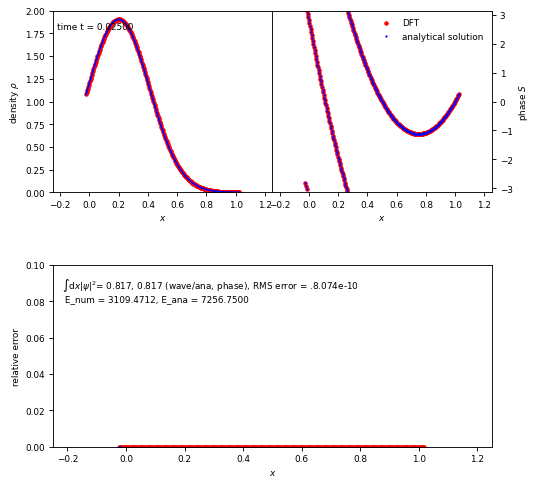

In [331]:

def sech(x):
    return 1 / np.cosh( x )


def spreader(x, dx, t, m = 1, hbar = 1):
    y = x
    A = 1j / ( 1j - 4 * np.tanh( 4 * t ) )
    B = - 8 * y ** 2 * sech(4 * t)**2
    C = 1j * 34 *  y ** 2 * np.tanh( 4 * t )
    D = 1 + 16 * np.tanh( 4 * t ) ** 2
    return A * np.exp((B + C) / D)


# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def gaussian(x, dx, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = generate1DGaussian(0, x, t, m, hbar, alpha)
    return psi


def planeWave(x, dx, t, m = 1, hbar = 1, alpha=1.0 / 10):
    return np.exp(1j * x)

def extraConfig(c):
    c["nThreads"] = 4
    c["resolution"] = 257
    #c["phaseYlim"] = [-100, 100]
    c["dpi"] = 80
    c["fps"] = 20
    c["slowDown"] = 300
    c["t0"] = 0.0
    c["tEnd"] = 0.025
    c["outputTimestep"] = False
    c["stencilOrder"] = 1
    c["timeOrder"] = 1
    c["C_parabolic"] = .1
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 2]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [-0.25, 1.25]
    c["domainSize"] = [0, 1]
    c["usePeriodicBC"] = True
    c["sigma0"] = 1e-8
    c["useAdaptiveTimestep"] = True 
    #c["dt"] = 1e-6
    c["sigma_index"] = 4
    c["boundarySize"] = 6
    c["patchSize"] = 16
    c["useBC"] = True
    c["replaceBoundary"] = True
    c["printGrid"] = False 
    c["mode"]               = FOURTH_ORDER
    c["derivative_mode"]    = MNONIC_PERIODIC
    c["BC"]                 = PERIODIC
    c["fd_boundary"]        = 0

import warnings
warnings.filterwarnings('error')
c = config.generateConfig()
extraConfig(c)
#scheme = SubregionScheme( c, jowettWave, HomogeneousCosineScheme )
#scheme = SubregionScheme( c, jowettWave, GAMERScheme)
#scheme = GAMERScheme( c, jowettWave )
scheme = DFTScheme( c, jowettWave )


scheme.run()

animation.drawFrame(solver = scheme, label = "DFT", analyticalSolution = jowettWave, filename = "Spreader", waveSolver = None)
plt.show() 


### Accuracy tests

Finished in 11 time steps
Finished in 43 time steps
Finished in 167 time steps


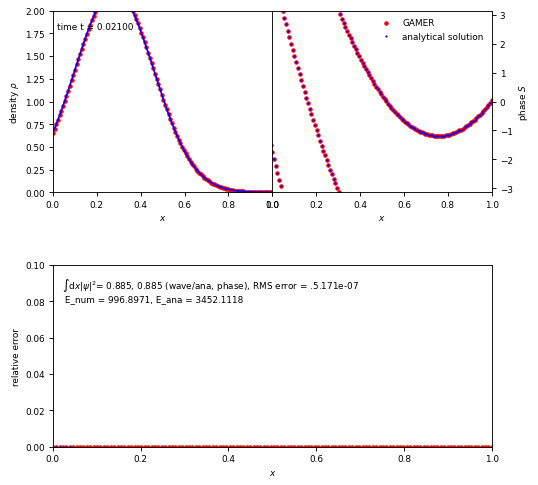

ValueError: Domain size needs to be integer multiple of patch size

In [332]:
def extraConfig(c):
    c["resolution"] = 32
    c["t0"] =  0.02
    c["tEnd"] = 0.021
    c["dpi"] = 80
    c["outputTimestep"] = False
    c["stencilOrder"] = 3
    c["timeOrder"] = 2
    c["C_parabolic"] = .1
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 2]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, 1]
    c["domainSize"] = [0, 1]
    c["usePeriodicBC"] = False
    c["useBC"] = True
    c["boundarySize"] = 16
    c["useAdaptiveTimestep"] = True 
    c["patchSize"] = 32
    c["printGrid"] = False
    c["replaceBoundary"] = True 

def setSine(c_org):
    c = dict(c_org)
    c["mode"]               = FOURTH_ORDER
    c["derivative_mode"]    = MLINEAR
    c["BC"]                 = DD
    c["fd_boundary"]        = 0
    return c

def setCosine(c_org):
    c = dict(c_org)
    c["mode"]               = FOURTH_ORDER
    c["derivative_mode"]    = MCUBIC_NN
    c["BC"]                 = NN
    c["fd_boundary"]        = 0
    return c

def setPeriodic(c_org):
    c = dict(c_org)
    c["mode"]               = FOURTH_ORDER
    c["derivative_mode"]    = MNONIC_PERIODIC
    c["BC"]                 = PERIODIC
    c["fd_boundary"]        = 0
    return c

c = config.generateConfig()
extraConfig(c)

#Homogeneous cosine scheme
cfull = dict(c)
cfull["useBC"] = True

c16 = dict(c)
c16["useBC"] = False
c16["timeOrder"] = 1
c16["patchSize"] = 16
c16["boundarySize"] = 6

c32 = dict(c)
c32["useBC"] = False
c32["timeOrder"] = 1
c32["patchSize"] = 32
c32["boundarySize"] = 12



schemes = [wave_schemes.GAMERScheme,
           lambda c, IC:  SubregionScheme(c, IC, GAMERScheme), 
           DFTScheme, 
           DFTScheme, 
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme),
           lambda c, IC:  SubregionScheme(c, IC, DFTScheme)]

names  = ["GAMER", 
          "GAMER (Patch size = 16)", 
          "Sine transform (whole domain)", 
          "Coine transform (whole domain)",
          "Periodic transform (whole domain)"
          "Sine (Patch size = 16)",
          "Cosine (Patch size = 16)",
          "Periodic (Patch size = 16)",
          "Sine (Patch size = 32)",
          "Cosine (Patch size = 32)",
          "Periodic (Patch size = 32)",
          ]

configs = [cfull, c16, setSine(cfull), setCosine(cfull), setPeriodic(cfull), setSine(c16), setCosine(c16), setPeriodic(c16), setSine(c32), setCosine(c32), setPeriodic(c32)]
test   = jowettWave
test_name = "jowett Wave"
resolutions = 2**np.arange(5, 8)
rel_errors = []
abs_errors = []

for i in range(len(schemes)):
    rel_error = []
    abs_error = []
    for resolution in resolutions:
        c = configs[i]
        c["resolution"] = resolution + 1
        scheme = (schemes[i])(c, test)
        scheme.run()
        rel_error.append(scheme.computeRelError())
        abs_error.append(scheme.computeRMSError())

        if resolution == resolutions[-1]:
            animation.drawFrame(solver = scheme, label = names[i], analyticalSolution = test)
            plt.show() 

    rel_errors.append(rel_error)
    abs_errors.append(abs_error)

plt.title("Relative errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, rel_errors[i], label=names[i])
plt.ylabel("Rel error in l_infty norm ")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()
plt.title("Absolute errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, abs_errors[i], label=names[i])
plt.ylabel("L2 error")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()

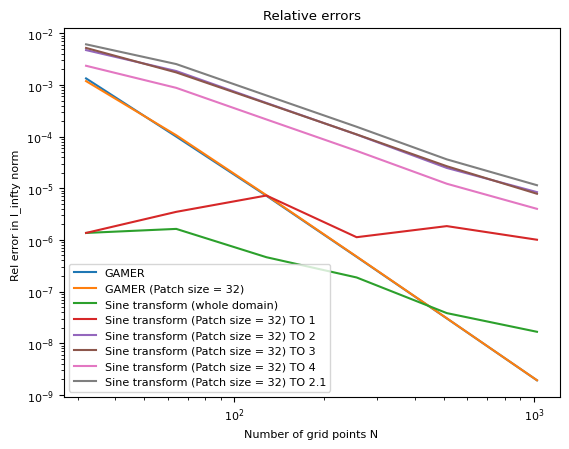

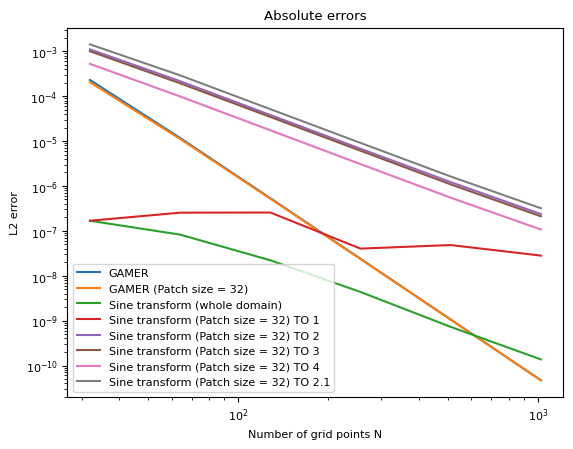

In [112]:

plt.title("Relative errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, rel_errors[i], label=names[i])
plt.ylabel("Rel error in l_infty norm ")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()
plt.title("Absolute errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, abs_errors[i], label=names[i])
plt.ylabel("L2 error")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()

Finished in 121 time steps
Finished in 497 time steps
Finished in 2017 time steps
Finished in 8129 time steps
Finished in 32641 time steps


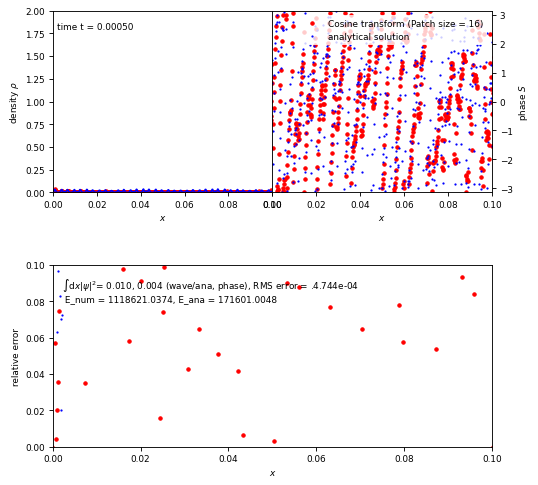

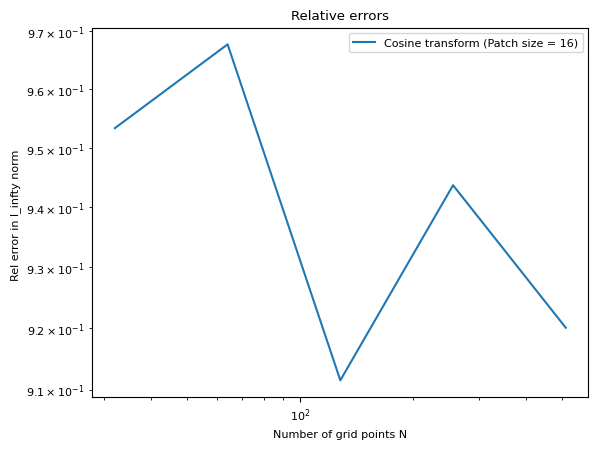

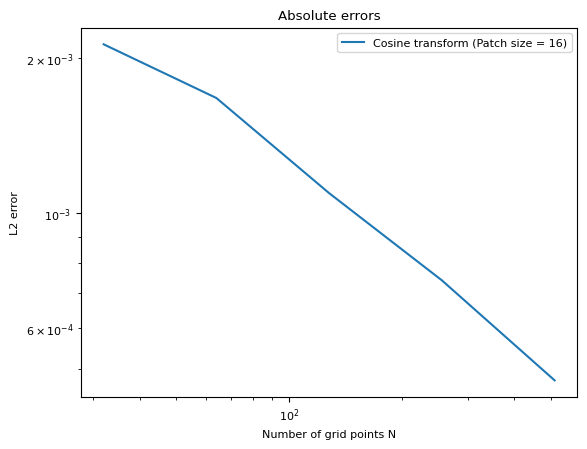

In [126]:
boundarySize = 6

def extraConfig(c):
    c["resolution"] = 32
    c["tEnd"] = 0.0005
    c["dpi"] = 80
    c["outputTimestep"] = False
    c["stencilOrder"] = 3
    c["timeOrder"] = 2
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 2]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, .1]
    c["domainSize"] = [0, .1]
    c["usePeriodicBC"] = False
    c["useBC"] = True
    c["boundarySize"] = boundarySize
    c["useAdaptiveTimestep"] = True 
    c["patchSize"] = 32
    c["replaceBoundary"] = True
    c["printGrid"] = False
    
c = config.generateConfig()
extraConfig(c)

#Regular GAMER scheme
c1 = dict(c)
#GAMER scheme with subregions
c2 = dict(c)
c2["useBC"] = False
c2["patchSize"] = 16
#Homogeneous sine scheme
c3 = dict(c)
c3["useBC"] = True
#Homogeneous cosine scheme with subpatches of size 16
c4 = dict(c)
c4["useBC"] = True
c4["patchSize"] = 16
#Homogeneous cosine scheme with subpatches of size 32
c5 = dict(c)
c5["useBC"] = False
c5["patchSize"] = 32

#schemes = [wave_schemes.GAMERScheme, HomogeneousCosineScheme, lambda c, IC: SubregionScheme(c, IC, HomogeneousCosineScheme), lambda c, IC: SubregionScheme(c, IC, HomogeneousCosineScheme)]
#names  = ["GAMER", "Sine transform (whole domain)", "Cosine transform (Patch size = 16)", "Cosine transform (Patch size = 32)"]
#configs = [c1, c3, c4, c5]

schemes = [lambda c, IC: SubregionScheme(c, IC, HomogeneousCosineScheme)]
names  = ["Cosine transform (Patch size = 16)"]
configs = [c4]
test   = multiWave
test_name = "multiWave"
resolutions = 2**np.arange(5, 10)
rel_errors = []
abs_errors = []

for i in range(len(schemes)):
    rel_error = []
    abs_error = []
    for resolution in resolutions:
        c = configs[i]
        c["resolution"] = resolution
        scheme = (schemes[i])(c, test)
        scheme.run()
        rel_error.append(scheme.computeRelError())
        abs_error.append(scheme.computeRMSError())

        if resolution == resolutions[-1]:
            animation.drawFrame(solver = scheme, label = names[i], analyticalSolution = test)
            plt.show() 

    rel_errors.append(rel_error)
    abs_errors.append(abs_error)

plt.title("Relative errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, rel_errors[i], label=names[i])
plt.ylabel("Rel error in l_infty norm ")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()
plt.title("Absolute errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, abs_errors[i], label=names[i])
plt.ylabel("L2 error")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()

dx:  0.0390625
Finished in 66 time steps


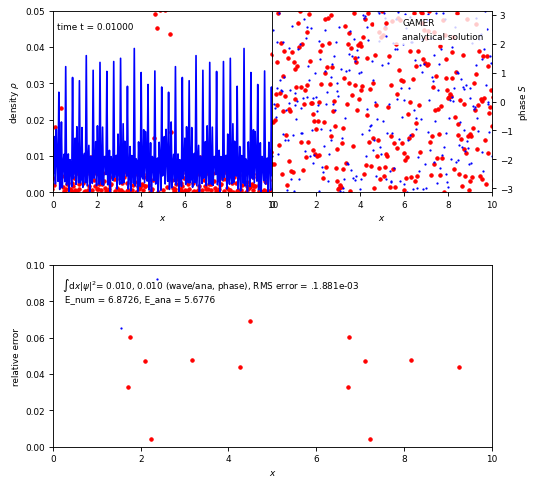

dx:  0.038910505836575876
Finished in 67 time steps


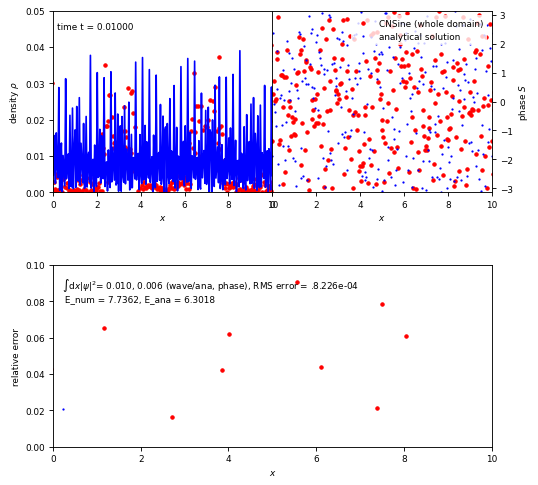

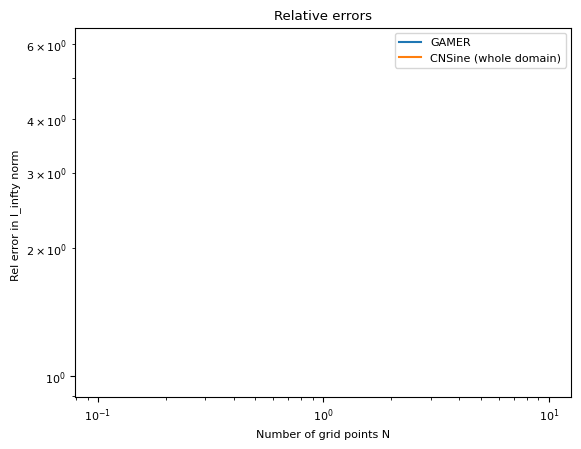

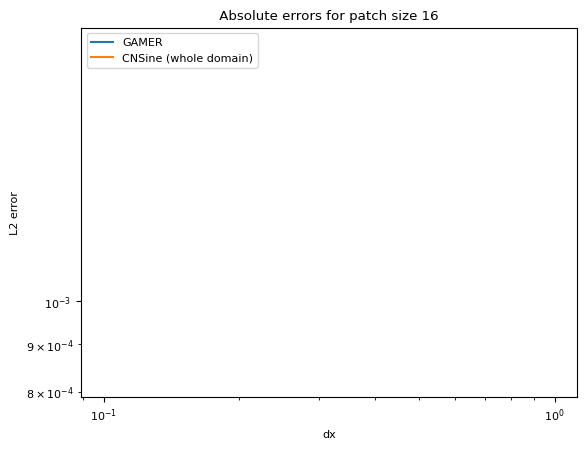

In [ ]:
boundarySize = 6
patchSize = 16

def multiWave(x, dx, t, hbar, m):
    L = 10
    psi = np.zeros(x.shape, complex)
    mu = np.arange(1, 1000, 10)
    for i in mu:
        k = 2*np.pi / L * i
        omega = k**2/2
        psi += np.exp(1j * (k*x-omega*t))

    psi /= len(mu)
    return psi

    

def extraConfig(c):
    c["resolution"] = 256
    c["tEnd"] = 0.01
    c["dpi"] = 80
    c["outputTimestep"] = False
    c["stencilOrder"] = 3
    c["timeOrder"] = 2
    c["C_parabolic"] = .1
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 0.05]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, .1]
    c["domainSize"] = [0, .1]
    c["usePeriodicBC"] = False 
    c["useBC"] = False
    c["boundarySize"] = boundarySize
    c["useAdaptiveTimestep"] = True 
    c["patchSize"] = patchSize
    c["printGrid"] = False
    
c = config.generateConfig()
extraConfig(c)

c1 = dict(c)
c2 = dict(c)
c2["useBC"] = True

schemes = [wave_schemes.GAMERScheme, HomogeneousSineScheme]
names  = ["GAMER", "CNSine (whole domain)", "Sine transform (whole domain)"]
configs = [c1, c2]
test   = multiWave
test_name = "Periodic 1D Gaussian"
resolutions = 2**np.arange(0, 1)
rel_errors = []
abs_errors = []

half_width = 5

for i in range(len(schemes)):
    rel_error = []
    abs_error = []
    for resolution in resolutions:
        c = configs[i]
        c["domainSize"] = [5 - half_width/resolution, 5 + half_width/resolution]
        scheme = (schemes[i])(c, test)
        print("dx: ", scheme.dx)
        scheme.run()
        rel_error.append(scheme.computeRelError())
        abs_error.append(scheme.computeRMSError())
        animation.drawFrame(solver = scheme, label = names[i], analyticalSolution = test)
        plt.savefig(f"{resolution}_{names[i]}.png")
        plt.show() 

    rel_errors.append(rel_error)
    abs_errors.append(abs_error)

plt.title("Relative errors")

for i in range(len(schemes)):
    plt.loglog(resolutions, rel_errors[i], label=names[i])
plt.ylabel("Rel error in l_infty norm ")
plt.xlabel("Number of grid points N")
plt.legend()
plt.show()
plt.title(f" Absolute errors for patch size {patchSize} ")

for i in range(len(schemes)):
    plt.loglog((10/resolutions)/patchSize, abs_errors[i], label=names[i])
plt.ylabel("L2 error")
plt.xlabel("dx")
plt.legend()
plt.show()

### Absorber Width Test

absorber width 0.48484848484848486 sigma0 1e-06
Finished in 273 time steps
absorber width 0.48484848484848486 sigma0 1.757510624854793e-06
Finished in 273 time steps
absorber width 0.48484848484848486 sigma0 3.0888435964774785e-06
Finished in 273 time steps
absorber width 0.48484848484848486 sigma0 5.428675439323859e-06
Finished in 273 time steps
absorber width 0.48484848484848486 sigma0 9.540954763499944e-06
Finished in 273 time steps
absorber width 0.48484848484848486 sigma0 1.67683293681101e-05
Finished in 273 time steps
absorber width 0.48484848484848486 sigma0 2.94705170255181e-05
Finished in 273 time steps
absorber width 0.48484848484848486 sigma0 5.1794746792312125e-05
Finished in 273 time steps
absorber width 0.48484848484848486 sigma0 9.102981779915228e-05
Finished in 273 time steps
absorber width 0.48484848484848486 sigma0 0.00015998587196060574
Finished in 273 time steps
absorber width 0.48484848484848486 sigma0 0.0002811768697974231
Finished in 273 time steps
absorber width

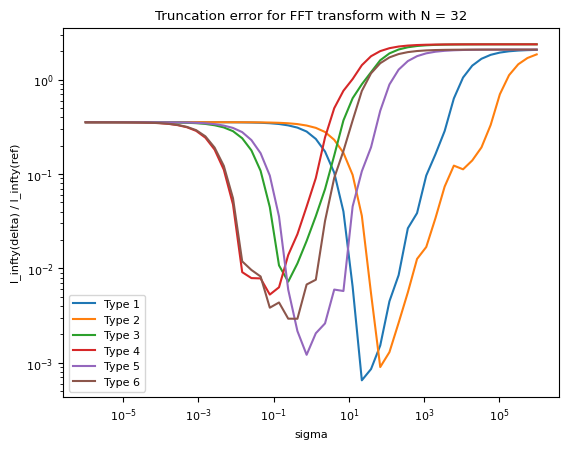

absorber width 0.49230769230769234 sigma0 1e-06
Finished in 1057 time steps
absorber width 0.49230769230769234 sigma0 1.757510624854793e-06
Finished in 1057 time steps
absorber width 0.49230769230769234 sigma0 3.0888435964774785e-06
Finished in 1057 time steps
absorber width 0.49230769230769234 sigma0 5.428675439323859e-06
Finished in 1057 time steps
absorber width 0.49230769230769234 sigma0 9.540954763499944e-06
Finished in 1057 time steps
absorber width 0.49230769230769234 sigma0 1.67683293681101e-05
Finished in 1057 time steps
absorber width 0.49230769230769234 sigma0 2.94705170255181e-05
Finished in 1057 time steps
absorber width 0.49230769230769234 sigma0 5.1794746792312125e-05
Finished in 1057 time steps
absorber width 0.49230769230769234 sigma0 9.102981779915228e-05
Finished in 1057 time steps
absorber width 0.49230769230769234 sigma0 0.00015998587196060574
Finished in 1057 time steps
absorber width 0.49230769230769234 sigma0 0.0002811768697974231
Finished in 1057 time steps
abs

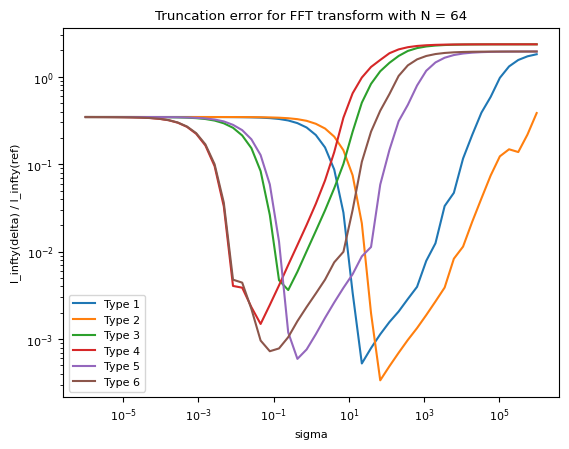

absorber width 0.49612403100775193 sigma0 1e-06
Finished in 4161 time steps
absorber width 0.49612403100775193 sigma0 1.757510624854793e-06
Finished in 4161 time steps
absorber width 0.49612403100775193 sigma0 3.0888435964774785e-06
Finished in 4161 time steps
absorber width 0.49612403100775193 sigma0 5.428675439323859e-06
Finished in 4161 time steps
absorber width 0.49612403100775193 sigma0 9.540954763499944e-06
Finished in 4161 time steps
absorber width 0.49612403100775193 sigma0 1.67683293681101e-05
Finished in 4161 time steps
absorber width 0.49612403100775193 sigma0 2.94705170255181e-05
Finished in 4161 time steps
absorber width 0.49612403100775193 sigma0 5.1794746792312125e-05
Finished in 4161 time steps
absorber width 0.49612403100775193 sigma0 9.102981779915228e-05
Finished in 4161 time steps
absorber width 0.49612403100775193 sigma0 0.00015998587196060574
Finished in 4161 time steps
absorber width 0.49612403100775193 sigma0 0.0002811768697974231
Finished in 4161 time steps
abs

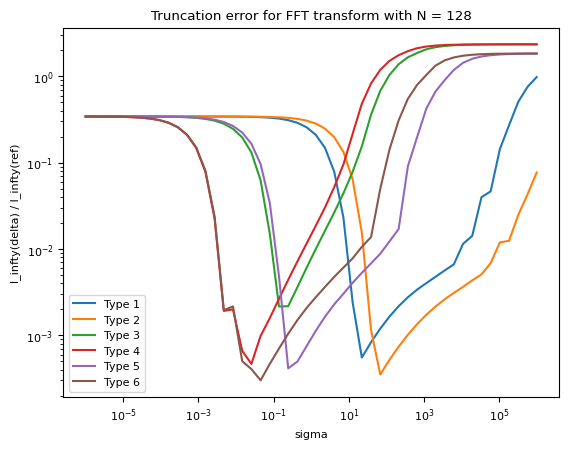

absorber width 0.4980544747081712 sigma0 1e-06
Finished in 16513 time steps
absorber width 0.4980544747081712 sigma0 1.757510624854793e-06


KeyboardInterrupt: 

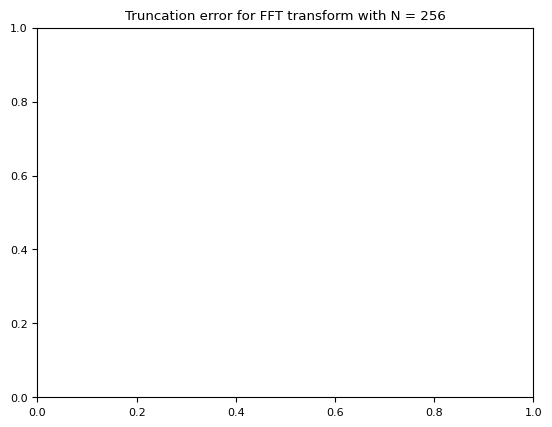

In [ ]:
def extraConfig(c):
    c["resolution"] = 32
    c["tEnd"] = 0.4
    c["dpi"] = 80
    c["outputTimestep"] = False
    c["stencilOrder"] = 4
    c["timeOrder"] = 4
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 25]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [-1, 1]
    c["domainSize"] = [-1, 1]
    c["usePeriodicBC"] = True
    c["boundarySize"] = 8
    c["sigma0"] = 1e-3
    c["sigma_index"] = 5
    c["useAdaptiveTimestep"] = True 
    c["useBC"] = True
    c["replaceBoundary"] = False
    
c = config.generateConfig()
extraConfig(c)

resolutions = 2**np.arange(5, 9)
minimal_errors = np.ones(len(resolutions)) * 1e6
minimal_method = np.zeros(len(resolutions))
minimal_sigmas = np.zeros(len(resolutions))

for j, resolution in enumerate(resolutions):
    plt.title(f"Truncation error for FFT transform with N = {resolution}")
    c["resolution"] = resolution
    c["boundarySize"] = 8 * 2**j
    for i in range(6):
        sigmas = np.logspace(-6, 6, 50)
        errors = []
        c["sigma_index"] = i 
        for sigma in sigmas:
            c["sigma0"] = sigma
            scheme = PMLFFTScheme(c, gaussian)
            scheme.run()
            errors.append(scheme.computeRelError())

        plt.loglog(sigmas, errors, label = f"Type {i+1}")
        minerr = np.min(errors)
        if (minerr < minimal_errors[j]):
            minimal_method[j] = i 
            minimal_errors[j] = minerr
            minimal_sigmas[j] = sigmas[np.argmin(errors)]

    plt.ylabel("l_infty(delta) / l_infty(ref)")
    plt.xlabel("sigma")
    plt.legend()
    plt.show()
    np


In [ ]:
minimal_errors, minimal_method, minimal_sigmas

(array([6.53088225e-04, 3.37609701e-04, 3.01414505e-04, 1.00000000e+06]),
 array([0., 1., 5., 0.]),
 array([2.22299648e+01, 6.86648845e+01, 4.49843267e-02, 0.00000000e+00]))

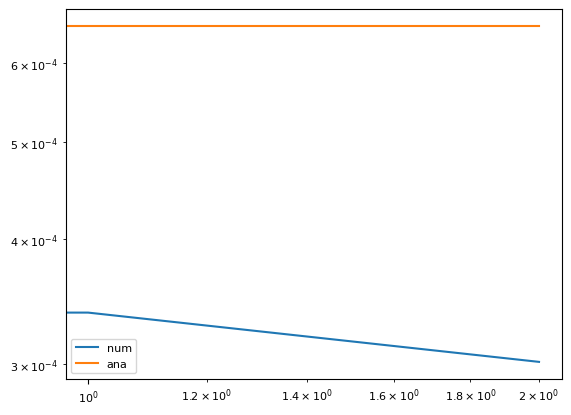

In [ ]:
plt.loglog(minimal_errors[:-1], label = "num")
plt.loglog(minimal_errors[0]/2**(np.arange(3) * 0), label="ana")
plt.legend()